In [1]:
pip install mlxtend

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import statistics
#from sklearn.preprocessing import Imputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import metrics, tree
from sklearn.metrics import roc_curve, auc
from sklearn.svm import SVC
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import BaggingClassifier,RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier, plot_tree


In [4]:
# file import and read - dataset 1
#==================================
#df = pd.read_csv(r"C:\Users\Shylu\Desktop\MS prep\2nd sem\ML\Assignment1\sgemm_product_dataset\sgemm_product.csv")
df_sgemm = pd.read_csv("sgemm_product.csv")
df_sgemm.describe()

# generate target variable as average of runs
df_sgemm['y']=(df_sgemm['Run1 (ms)']+df_sgemm['Run2 (ms)']+df_sgemm['Run3 (ms)']+df_sgemm['Run4 (ms)'])/4

#print(df['y'])
# remove extra fields in data set
df_sgemm.drop(['Run1 (ms)', 'Run2 (ms)','Run3 (ms)', 'Run4 (ms)'], axis=1, inplace=True)


In [5]:
# remove outliers above or below 3 standard deviations from mean
#=================================================================

df_sgemm = df_sgemm[~(np.abs(df_sgemm['y']-df_sgemm['y'].mean()) > (3*df_sgemm['y'].std()))] 
df_sgemm_orig = df_sgemm.copy()
df_sgemm

#236349 rows 

MWG  NWG  KWG  MDIMC  NDIMC  MDIMA  NDIMB  KWI  VWM  VWN  STRM  STRN  \
0        16   16   16      8      8      8      8    2    1    1     0     0   
1        16   16   16      8      8      8      8    2    1    1     0     0   
2        16   16   16      8      8      8      8    2    1    1     0     0   
3        16   16   16      8      8      8      8    2    1    1     0     0   
4        16   16   16      8      8      8      8    2    1    1     0     1   
...     ...  ...  ...    ...    ...    ...    ...  ...  ...  ...   ...   ...   
241595  128  128   32     32     32     32     32    8    4    4     1     0   
241596  128  128   32     32     32     32     32    8    4    4     1     1   
241597  128  128   32     32     32     32     32    8    4    4     1     1   
241598  128  128   32     32     32     32     32    8    4    4     1     1   
241599  128  128   32     32     32     32     32    8    4    4     1     1   

        SA  SB         y  
0        0   0  116.3700  
1        0   1   78.7050  
2        1   0   80.5650  
3        1   1   86.6375  
4        0   0  118.6625  
...     ..  ..       ...  
241595   1   1   17.8175  
241596   0   0   36.0350  
241597   0   1   35.1600  
241598   1   0   28.4525  
241599   1   1   17.8175  

[236349 rows x 15 columns]

In [6]:
# convert y to logistic
#========================
# df_sgemm['y'].mean()  = 175.549
#(df_sgemm['y'].apply(lambda x: 1 if x>175 else 0 ) ).sum() = 69707

cut_off = round(df_sgemm['y'].mean())
df_sgemm['y'] = df_sgemm['y'].apply(lambda x: 1 if x>cut_off else 0 ) 

# normalize dataset
#======================

cols_to_norm = ['MWG','NWG', 'KWG','MDIMC','NDIMC','MDIMA','NDIMB','KWI','VWM','VWN']
df_sgemm[cols_to_norm] = StandardScaler().fit_transform(df_sgemm[cols_to_norm])
df_sgemm

df_sgemm

MWG       NWG       KWG     MDIMC     NDIMC    MDIMA     NDIMB  \
0      -1.498672 -1.498506 -1.198399 -0.767081 -0.767081 -0.99866 -0.998592   
1      -1.498672 -1.498506 -1.198399 -0.767081 -0.767081 -0.99866 -0.998592   
2      -1.498672 -1.498506 -1.198399 -0.767081 -0.767081 -0.99866 -0.998592   
3      -1.498672 -1.498506 -1.198399 -0.767081 -0.767081 -0.99866 -0.998592   
4      -1.498672 -1.498506 -1.198399 -0.767081 -0.767081 -0.99866 -0.998592   
...          ...       ...       ...       ...       ...      ...       ...   
241595  1.141691  1.142262  0.834446  2.266972  2.266972  1.55808  1.558444   
241596  1.141691  1.142262  0.834446  2.266972  2.266972  1.55808  1.558444   
241597  1.141691  1.142262  0.834446  2.266972  2.266972  1.55808  1.558444   
241598  1.141691  1.142262  0.834446  2.266972  2.266972  1.55808  1.558444   
241599  1.141691  1.142262  0.834446  2.266972  2.266972  1.55808  1.558444   

             KWI       VWM       VWN  STRM  STRN  SA  SB  y  
0      -0.999065 -0.738004 -0.737814     0     0   0   0  0  
1      -0.999065 -0.738004 -0.737814     0     0   0   1  0  
2      -0.999065 -0.738004 -0.737814     0     0   1   0  0  
3      -0.999065 -0.738004 -0.737814     0     0   1   1  0  
4      -0.999065 -0.738004 -0.737814     0     1   0   0  0  
...          ...       ...       ...   ...   ...  ..  .. ..  
241595  1.000935  0.810380  0.808556     1     0   1   1  0  
241596  1.000935  0.810380  0.808556     1     1   0   0  0  
241597  1.000935  0.810380  0.808556     1     1   0   1  0  
241598  1.000935  0.810380  0.808556     1     1   1   0  0  
241599  1.000935  0.810380  0.808556     1     1   1   1  0  

[236349 rows x 15 columns]

In [7]:
# split into train and test data set (70/30)
sgemm_train, sgemm_test = train_test_split(df_sgemm,train_size=0.7, test_size=0.3, random_state=0)

print(len(sgemm_train))
print(len(sgemm_test))

165444
70905


In [8]:
# for svm taking only first 20,000 rows of dataset. To reduce time complexity
df_sgemm_svm = df_sgemm.head(20000)
sgemm_train_svm, sgemm_test_svm = train_test_split(df_sgemm_svm,train_size=0.7, test_size=0.3, random_state=0)

print(len(sgemm_train_svm))
print(len(sgemm_test_svm))

14000
6000


In [9]:
# file import and read - dataset 2
#==================================
#df = pd.read_csv(r"C:\Users\Shylu\Desktop\MS prep\2nd sem\ML\Assignment1\sgemm_product_dataset\sgemm_product.csv")
df_mush = pd.read_csv("mushrooms.csv")
print(df_mush.describe())

df_mush

       class cap-shape cap-surface cap-color bruises  odor gill-attachment  \
count   8124      8124        8124      8124    8124  8124            8124   
unique     2         6           4        10       2     9               2   
top        e         x           y         n       f     n               f   
freq    4208      3656        3244      2284    4748  3528            7914   

       gill-spacing gill-size gill-color  ... stalk-surface-below-ring  \
count          8124      8124       8124  ...                     8124   
unique            2         2         12  ...                        4   
top               c         b          b  ...                        s   
freq           6812      5612       1728  ...                     4936   

       stalk-color-above-ring stalk-color-below-ring veil-type veil-color  \
count                    8124                   8124      8124       8124   
unique                      9                      9         1          4   
top    

class cap-shape cap-surface cap-color bruises odor gill-attachment  \
0        p         x           s         n       t    p               f   
1        e         x           s         y       t    a               f   
2        e         b           s         w       t    l               f   
3        p         x           y         w       t    p               f   
4        e         x           s         g       f    n               f   
...    ...       ...         ...       ...     ...  ...             ...   
8119     e         k           s         n       f    n               a   
8120     e         x           s         n       f    n               a   
8121     e         f           s         n       f    n               a   
8122     p         k           y         n       f    y               f   
8123     e         x           s         n       f    n               a   

     gill-spacing gill-size gill-color  ... stalk-surface-below-ring  \
0               c         n          k  ...                        s   
1               c         b          k  ...                        s   
2               c         b          n  ...                        s   
3               c         n          n  ...                        s   
4               w         b          k  ...                        s   
...           ...       ...        ...  ...                      ...   
8119            c         b          y  ...                        s   
8120            c         b          y  ...                        s   
8121            c         b          n  ...                        s   
8122            c         n          b  ...                        k   
8123            c         b          y  ...                        s   

     stalk-color-above-ring stalk-color-below-ring veil-type veil-color  \
0                         w                      w         p          w   
1                         w                      w         p          w   
2                         w                      w         p          w   
3                         w                      w         p          w   
4                         w                      w         p          w   
...                     ...                    ...       ...        ...   
8119                      o                      o         p          o   
8120                      o                      o         p          n   
8121                      o                      o         p          o   
8122                      w                      w         p          w   
8123                      o                      o         p          o   

     ring-number ring-type spore-print-color population habitat  
0              o         p                 k          s       u  
1              o         p                 n          n       g  
2              o         p                 n          n       m  
3              o         p                 k          s       u  
4              o         e                 n          a       g  
...          ...       ...               ...        ...     ...  
8119           o         p                 b          c       l  
8120           o         p                 b          v       l  
8121           o         p                 b          c       l  
8122           o         e                 w          v       l  
8123           o         p                 o          c       l  

[8124 rows x 23 columns]

In [10]:
#imputing missing stalk-root values with most frequent value
#=============================================================

missing = (df_mush['stalk-root'].apply(lambda x:1 if x=='?' else 0)).sum()
print(missing)
print(df_mush['stalk-root'].value_counts())

df_mush = df_mush.replace('?',np.NaN)
print((df_mush['stalk-root'].isnull()).sum())

df_mush = df_mush.apply(lambda x: x.fillna(x.value_counts().index[0]))
#df_mush

print(df_mush['stalk-root'].value_counts())
print((df_mush['stalk-root'].isnull()).sum())


2480
b    3776
?    2480
e    1120
c     556
r     192
Name: stalk-root, dtype: int64
2480
b    6256
e    1120
c     556
r     192
Name: stalk-root, dtype: int64
0


In [11]:
#converting binary value columns into 0 and 1

df_mush['class'] = df_mush['class'].apply(lambda x: 1 if x=='p' else 0)
df_mush['bruises'] = df_mush['bruises'].apply(lambda x: 1 if x=='t' else 0)
df_mush['gill-attachment'] = df_mush['gill-attachment'].apply(lambda x: 1 if x=='a' else 0)
df_mush['gill-spacing'] = df_mush['gill-spacing'].apply(lambda x: 1 if x=='c' else 0)
df_mush['gill-size'] = df_mush['gill-size'].apply(lambda x: 1 if x=='b' else 0)
df_mush['stalk-shape'] = df_mush['stalk-shape'].apply(lambda x: 1 if x=='e' else 0)
df_mush['veil-type'] = df_mush['veil-type'].apply(lambda x: 1 if x=='p' else 0)

df_mush

class cap-shape cap-surface cap-color  bruises odor  gill-attachment  \
0         1         x           s         n        1    p                0   
1         0         x           s         y        1    a                0   
2         0         b           s         w        1    l                0   
3         1         x           y         w        1    p                0   
4         0         x           s         g        0    n                0   
...     ...       ...         ...       ...      ...  ...              ...   
8119      0         k           s         n        0    n                1   
8120      0         x           s         n        0    n                1   
8121      0         f           s         n        0    n                1   
8122      1         k           y         n        0    y                0   
8123      0         x           s         n        0    n                1   

      gill-spacing  gill-size gill-color  ...  stalk-surface-below-ring  \
0                1          0          k  ...                         s   
1                1          1          k  ...                         s   
2                1          1          n  ...                         s   
3                1          0          n  ...                         s   
4                0          1          k  ...                         s   
...            ...        ...        ...  ...                       ...   
8119             1          1          y  ...                         s   
8120             1          1          y  ...                         s   
8121             1          1          n  ...                         s   
8122             1          0          b  ...                         k   
8123             1          1          y  ...                         s   

     stalk-color-above-ring stalk-color-below-ring veil-type veil-color  \
0                         w                      w         1          w   
1                         w                      w         1          w   
2                         w                      w         1          w   
3                         w                      w         1          w   
4                         w                      w         1          w   
...                     ...                    ...       ...        ...   
8119                      o                      o         1          o   
8120                      o                      o         1          n   
8121                      o                      o         1          o   
8122                      w                      w         1          w   
8123                      o                      o         1          o   

     ring-number  ring-type spore-print-color population habitat  
0              o          p                 k          s       u  
1              o          p                 n          n       g  
2              o          p                 n          n       m  
3              o          p                 k          s       u  
4              o          e                 n          a       g  
...          ...        ...               ...        ...     ...  
8119           o          p                 b          c       l  
8120           o          p                 b          v       l  
8121           o          p                 b          c       l  
8122           o          e                 w          v       l  
8123           o          p                 o          c       l  

[8124 rows x 23 columns]

In [12]:
#columns with more than 2 values. Split and pivot them
df_mush_trans = pd.get_dummies(df_mush, prefix=['cap-shape', 'cap-surface', 'cap-color', 'odor', 'gill-color','stalk-root', 
                                            'stalk-surface-above-ring','stalk-surface-below-ring', 'stalk-color-above-ring',
                                            'stalk-color-below-ring', 'veil-color', 'ring-number','ring-type', 
                                            'spore-print-color', 'population', 'habitat'])
df_mush_trans

class  bruises  gill-attachment  gill-spacing  gill-size  stalk-shape  \
0         1        1                0             1          0            1   
1         0        1                0             1          1            1   
2         0        1                0             1          1            1   
3         1        1                0             1          0            1   
4         0        0                0             0          1            0   
...     ...      ...              ...           ...        ...          ...   
8119      0        0                1             1          1            1   
8120      0        0                1             1          1            1   
8121      0        0                1             1          1            1   
8122      1        0                0             1          0            0   
8123      0        0                1             1          1            1   

      veil-type  cap-shape_b  cap-shape_c  cap-shape_f  ...  population_s  \
0             1            0            0            0  ...             1   
1             1            0            0            0  ...             0   
2             1            1            0            0  ...             0   
3             1            0            0            0  ...             1   
4             1            0            0            0  ...             0   
...         ...          ...          ...          ...  ...           ...   
8119          1            0            0            0  ...             0   
8120          1            0            0            0  ...             0   
8121          1            0            0            1  ...             0   
8122          1            0            0            0  ...             0   
8123          1            0            0            0  ...             0   

      population_v  population_y  habitat_d  habitat_g  habitat_l  habitat_m  \
0                0             0          0          0          0          0   
1                0             0          0          1          0          0   
2                0             0          0          0          0          1   
3                0             0          0          0          0          0   
4                0             0          0          1          0          0   
...            ...           ...        ...        ...        ...        ...   
8119             0             0          0          0          1          0   
8120             1             0          0          0          1          0   
8121             0             0          0          0          1          0   
8122             1             0          0          0          1          0   
8123             0             0          0          0          1          0   

      habitat_p  habitat_u  habitat_w  
0             0          1          0  
1             0          0          0  
2             0          0          0  
3             0          1          0  
4             0          0          0  
...         ...        ...        ...  
8119          0          0          0  
8120          0          0          0  
8121          0          0          0  
8122          0          0          0  
8123          0          0          0  

[8124 rows x 112 columns]

In [13]:
#labelencoder=LabelEncoder()
#for col in df_mush.columns:
#    df_mush[col]=labelencoder.fit_transform(df_mush[col])

#onehotencoder = OneHotEncoder(categorical_features = [1,2,3,5,9,11,12,13,14,15,17,18,19,20,21,22])
#data = onehotencoder.fit_transform(df_mush).toarray().astype(int)
#col_name = onehotencoder.get_feature_names(['cap-shape', 'cap-surface', 'cap-color', 'odor', 'gill-color','stalk-root', 
#                                            'stalk-surface-above-ring','stalk-surface-below-ring', 'stalk-color-above-ring',
#                                            'stalk-color-below-ring', 'veil-color', 'ring-number','ring-type', 
#                                            'spore-print-color', 'population', 'habitat'])  # set column names
#df_mush = pd.DataFrame(data, columns=col_name)


In [14]:
# split into train and test data set (70/30)
mush_train, mush_test = train_test_split(df_mush_trans,train_size=0.7, test_size=0.3, random_state=0)

print(len(mush_train))
print(len(mush_test))

5686
2438


In [15]:
def logistic_reg(xtrain_train,ytrain_train, xtrain_test, ytrain_test,xtest_test, ytest_test):
    logreg = LogisticRegression(solver='lbfgs')
    logreg.fit(xtrain_train,ytrain_train)
    
    y_pred_in_sample = logreg.predict(xtrain_test) # predict in sample y    
    #cnf_matrix_in_sample = metrics.confusion_matrix(ytrain_train, y_pred_in_sample)
    
    y_pred_out_of_sample = logreg.predict(xtest_test) # predict out of sample y    
    #cnf_matrix_out_of_sample = metrics.confusion_matrix(ytest_test, y_pred_out_of_sample)
    
    return metrics.accuracy_score(ytrain_test, y_pred_in_sample), metrics.accuracy_score(ytest_test, y_pred_out_of_sample) #, cnf_matrix_in_sample, cnf_matrix_out_of_sample
    

In [16]:
def fn_svm(xtrain_train,ytrain_train, xtrain_test, ytrain_test,xtest_test, ytest_test, kernel_type, c, degree, gamma):
    
    if kernel_type == "linear":
        clf = SVC(kernel=kernel_type, C=c)# C = Regularization parameter. It tells how much you want to avoid misclassifying each training example. For large values of C, the optimization will choose a smaller-margin hyperplane if that hyperplane does a better job of getting all the training points classified correctly
    else:
        clf = SVC(kernel=kernel_type, C=c, degree=degree, gamma=gamma)
       
    clf.fit(xtrain_train, ytrain_train)
    
    y_pred_in_sample = clf.predict(xtrain_test)   
    y_pred_out_of_sample = clf.predict(xtest_test)
    
    SVM_acc_train=clf.score(xtrain_test,ytrain_test.ravel())
    SVM_acc_test=clf.score(xtest_test,ytest_test.ravel())
    
    #plotting - using PCA
    y=np.asarray(ytrain_train)
    pca = PCA(n_components = 2)
    X = pca.fit_transform(xtrain_train)
    clf.fit(X, y)
    
    print("plotting in sample")
    plot_svm(clf,xtrain_test,ytrain_test)
    
    print("plotting out of sample")
    plot_svm(clf,xtest_test,ytest_test)
    
    return SVM_acc_train, SVM_acc_test
    

In [17]:
def plot_svm(model,x,y):    
    #convert to lower dimension using PCA for plotting
    y=np.asarray(y)
    pca = PCA(n_components = 2)
    X = pca.fit_transform(x)
    plot_decision_regions(X, y, clf=model, legend=2)

    plt.title('SVM Decision Region Boundary', size=16)

    plt.show()    
  

In [18]:
def fn_DT_gini(xtrain_train,ytrain_train, xtrain_test, ytrain_test,xtest_test, ytest_test):
    # decision tree classifier based on gini index 
    #clf_gini = DecisionTreeClassifier(criterion = "gini", random_state = 100,max_depth=3, min_samples_leaf=5) 
    clf_gini = DecisionTreeClassifier(criterion = "gini") # fully grown tree

    clf_gini.fit(xtrain_train, ytrain_train)
    
    y_pred_in_sample = clf_gini.predict(xtrain_test)   
    y_pred_out_of_sample = clf_gini.predict(xtest_test)
    
    return metrics.accuracy_score(ytrain_test, y_pred_in_sample), metrics.accuracy_score(ytest_test, y_pred_out_of_sample)

In [19]:
def fn_DT_entropy(xtrain_train,ytrain_train, xtrain_test, ytrain_test,xtest_test, ytest_test):
    # decision tree classifier based on entropy 
   # clf_entropy = DecisionTreeClassifier(criterion = "entropy", random_state = 100,max_depth=3, min_samples_leaf=5) 
    clf_entropy = DecisionTreeClassifier(criterion = "entropy") # fully grown tree

    clf_entropy.fit(xtrain_train, ytrain_train)
    
    y_pred_in_sample = clf_entropy.predict(xtrain_test)   
    y_pred_out_of_sample = clf_entropy.predict(xtest_test)

    return metrics.accuracy_score(ytrain_test, y_pred_in_sample), metrics.accuracy_score(ytest_test, y_pred_out_of_sample)

In [20]:
def fn_bagging(xtrain_train,ytrain_train, xtrain_test, ytrain_test,xtest_test, ytest_test,num_trees):
    clf = DecisionTreeClassifier(criterion = "gini") 
    model = BaggingClassifier(base_estimator=clf, n_estimators=num_trees)
      
    model.fit(xtrain_train, ytrain_train)
    
    y_pred_in_sample = model.predict(xtrain_test)   
    y_pred_out_of_sample = model.predict(xtest_test)

    return metrics.accuracy_score(ytrain_test, y_pred_in_sample), metrics.accuracy_score(ytest_test, y_pred_out_of_sample)

In [21]:
def fn_random_forest(xtrain_train,ytrain_train, xtrain_test, ytrain_test,xtest_test, ytest_test,num_trees,max_features): 
    model = RandomForestClassifier(n_estimators=num_trees, max_features=max_features)
      
    model.fit(xtrain_train, ytrain_train)
    
    y_pred_in_sample = model.predict(xtrain_test)   
    y_pred_out_of_sample = model.predict(xtest_test)

    return metrics.accuracy_score(ytrain_test, y_pred_in_sample), metrics.accuracy_score(ytest_test, y_pred_out_of_sample)

In [22]:
def fn_adaboost(xtrain_train,ytrain_train, xtrain_test, ytrain_test,xtest_test, ytest_test,num_trees): 
    model = AdaBoostClassifier(n_estimators=num_trees)
      
    model.fit(xtrain_train, ytrain_train)
    
    y_pred_in_sample = model.predict(xtrain_test)   
    y_pred_out_of_sample = model.predict(xtest_test)

    return metrics.accuracy_score(ytrain_test, y_pred_in_sample), metrics.accuracy_score(ytest_test, y_pred_out_of_sample)

In [23]:
def fn_gradient_boost(xtrain_train,ytrain_train, xtrain_test, ytrain_test,xtest_test, ytest_test,num_trees): 
    model = GradientBoostingClassifier(n_estimators=num_trees)
      
    model.fit(xtrain_train, ytrain_train)
    
    y_pred_in_sample = model.predict(xtrain_test)   
    y_pred_out_of_sample = model.predict(xtest_test)

    return metrics.accuracy_score(ytrain_test, y_pred_in_sample), metrics.accuracy_score(ytest_test, y_pred_out_of_sample)

In [29]:
# cross validation
#==================
def cross_validation(xtrain,ytrain,xtest,ytest,fn_id,num_trees=100,max_features=5, c=1, degree = 3, gamma = 'auto', nfold=4):
    k=nfold
    i=0
    n_train=xtrain.shape[0]
    n_test=xtest.shape[0]
    accuracy_train= []
    accuracy_test = []
    arr_fpr = []
    arr_tpr = []
    
    for i in range(k):
        xtrain_test = xtrain[int(i*n_train/k):int((i+1)*n_train/k)]
        ytrain_test = ytrain[int(i*n_train/k):int((i+1)*n_train/k)]
        xtest_test = xtest[int(i*n_test/k):int((i+1)*n_test/k)]
        ytest_test = ytest[int(i*n_test/k):int((i+1)*n_test/k)]
        
        xtrain_train_lower = xtrain[:int(i*n_train/k)]
        ytrain_train_lower = ytrain[:int(i*n_train/k)]
        #xtest_train_lower = xtest[:int(i*n/k)]
        #ytest_train_lower = ytest[:int(i*n/k)]
        xtrain_train_upper = xtrain[int((i+1)*n_train/k):]
        ytrain_train_upper = ytrain[int((i+1)*n_train/k):]
        #xtest_train_upper = xtest[int((i+1)*n/k):]
        #ytest_train_upper = ytest[int((i+1)*n/k):]
                
        xtrain_train = np.concatenate((xtrain_train_lower,xtrain_train_upper))
        ytrain_train = np.concatenate((ytrain_train_lower,ytrain_train_upper))
        #xtest_train = np.concatenate((xtest_train_lower,xtest_train_upper))
        #ytest_train = np.concatenate((ytest_train_lower,ytest_train_upper))
        
        if fn_id==1:  # logistic regression
            acc_train, acc_test = logistic_reg(xtrain_train,ytrain_train, xtrain_test, ytrain_test,xtest_test, ytest_test)
        
        elif fn_id==2:  #Linear svm
            print(i)
            print("Linear svm kernel")
            acc_train, acc_test = fn_svm(xtrain_train,ytrain_train, xtrain_test, ytrain_test,xtest_test, ytest_test, 'linear', c, degree, gamma)
       
        elif fn_id==3:  # Polynomial svm  
            print(i)
            print("Polynomial svm kernel")
            acc_train, acc_test = fn_svm(xtrain_train,ytrain_train, xtrain_test, ytrain_test,xtest_test, ytest_test, 'poly', c, degree, gamma)
        
        elif fn_id==4:  #rbf svm 
            print(i)
            print("Radial Basis Function svm kernel")
            acc_train, acc_test = fn_svm(xtrain_train,ytrain_train, xtrain_test, ytrain_test,xtest_test, ytest_test, 'rbf', c, degree, gamma)
        
        elif fn_id==5:  #DT using Gini Index
           # print(i)
           # print("Decision Tree using Gini Index")
            acc_train, acc_test = fn_DT_gini(xtrain_train,ytrain_train, xtrain_test, ytrain_test,xtest_test, ytest_test)    
            
        elif fn_id==6:  #DT using Entropy
            #print(i)
            #print("Decision Tree using Entropy")
            acc_train, acc_test = fn_DT_entropy(xtrain_train,ytrain_train, xtrain_test, ytrain_test,xtest_test, ytest_test)
        
        elif fn_id==7: #bagging
            acc_train, acc_test = fn_bagging(xtrain_train,ytrain_train, xtrain_test, ytrain_test,xtest_test, ytest_test, num_trees)
            
        elif fn_id==8: #random forest
            acc_train, acc_test = fn_random_forest(xtrain_train,ytrain_train, xtrain_test, ytrain_test,xtest_test, ytest_test, num_trees, max_features)    
          
        elif fn_id==9: #Adaboost
            acc_train, acc_test = fn_adaboost(xtrain_train,ytrain_train, xtrain_test, ytrain_test,xtest_test, ytest_test, num_trees)    
        
        elif fn_id==10: #stochastic gradient boost
            acc_train, acc_test= fn_gradient_boost(xtrain_train,ytrain_train, xtrain_test, ytrain_test,xtest_test, ytest_test, num_trees)    
        
         
        accuracy_train.append(acc_train)
        accuracy_test.append(acc_test)
       # print(accuracy_train)
       # print(accuracy_test)
            
    return accuracy_train, accuracy_test #, cnf_matrix_train, cnf_matrix_test


In [25]:

# Dataset 1 = sgemm product 
#===========================
sgemm_train_x = sgemm_train[sgemm_train.columns.difference(['y'])]  # take all other columns except y
sgemm_train_y = sgemm_train['y']
sgemm_test_x = sgemm_test[sgemm_test.columns.difference(['y'])] 
sgemm_test_y = sgemm_test['y']

#for implementing svm
#=====================
sgemm_train_svm_x = sgemm_train_svm[sgemm_train_svm.columns.difference(['y'])]  # take all other columns except y
sgemm_train_svm_y = sgemm_train_svm['y']
sgemm_test_svm_x = sgemm_test_svm[sgemm_test_svm.columns.difference(['y'])] 
sgemm_test_svm_y = sgemm_test_svm['y']

# Dataset 2 = mushroom
#======================
mush_train_x = mush_train[mush_train.columns.difference(['class'])]  # take all other columns except class
mush_train_y = mush_train['class']
mush_test_x = mush_test[mush_test.columns.difference(['class'])] 
mush_test_y = mush_test['class']


# Logistic regression using cross validation

In [26]:
# Dataset 1 = sgemm product 
#===========================

#cross validation using logistic regression
acc_train, acc_test = cross_validation(sgemm_train_x, sgemm_train_y, sgemm_test_x, sgemm_test_y, 1)
#, cnf_matrix_train, cnf_matrix_test

print("In Sample accuracy from logistic regression is {0}".format(acc_train))
print("Out of Sample accuracy from logistic regression is {0}".format(acc_test))

#print("In Sample confusion matrix is")
#print(cnf_matrix_train)

print(" ")

print("Average In Sample accuracy from logistic regression is {0}".format(statistics.mean(acc_train)))
print("Average Out of Sample accuracy from logistic regression is {0}".format(statistics.mean(acc_test)))


In Sample accuracy from logistic regression is [0.9212059669737193, 0.9213510311646237, 0.9218104011024878, 0.9242523149827132]
Out of Sample accuracy from logistic regression is [0.921527699424574, 0.9241791718379782, 0.9174658693444657, 0.921701359508095]
 
Average In Sample accuracy from logistic regression is 0.922154928555886
Average Out of Sample accuracy from logistic regression is 0.9212185250287782


In [27]:
# Dataset 2 = mushroom
#======================

acc_train, acc_test = cross_validation(mush_train_x, mush_train_y,mush_test_x, mush_test_y, 1)
#, cnf_matrix_train, cnf_matrix_test

print("In Sample accuracy from logistic regression is {0}".format(acc_train))
print("Out of Sample accuracy from logistic regression is {0}".format(acc_test))
print(" ")
print("Average In Sample accuracy from logistic regression is {0}".format(statistics.mean(acc_train)))
print("Average Out of Sample accuracy from logistic regression is {0}".format(statistics.mean(acc_test)))


In Sample accuracy from logistic regression is [1.0, 0.9978902953586498, 1.0, 0.9992967651195499]
Out of Sample accuracy from logistic regression is [1.0, 1.0, 1.0, 0.9983606557377049]
 
Average In Sample accuracy from logistic regression is 0.9992967651195499
Average Out of Sample accuracy from logistic regression is 0.9995901639344262


## Experiment with multiple folds for cross validation

[0.921997775682406, 0.9220642630232992, 0.922028037142124, 0.9221246600866391, 0.9220581953216156, 0.9220943609437328, 0.9220884571687422, 0.9221065191505979, 0.9220699124943775]
[0.9214583085384661, 0.9210916014385445, 0.9211057302816757, 0.9211480621029883, 0.9212325074472876, 0.9211616198903021, 0.9212182800611852, 0.92117643721408, 0.921190578499244]


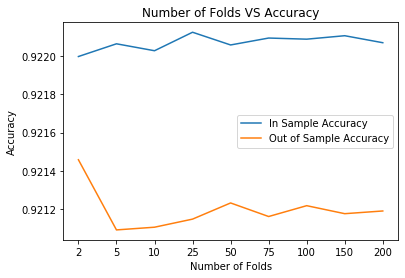

In [35]:
# Dataset 1 = sgemm product 
#===========================

fold = [2,5,10,25,50,75,100,150,200]
a_train=[]
a_test=[]

for i in fold:
    acc_train, acc_test = cross_validation(sgemm_train_x, sgemm_train_y, sgemm_test_x, sgemm_test_y, 1, 100,5,1,3,'auto',i)
    a_train.append(statistics.mean(acc_train))
    a_test.append(statistics.mean(acc_test))
print(a_train)
print(a_test)

xi = list(range(len(fold)))
plt.title("Number of Folds VS Accuracy")
plt.xlabel("Number of Folds")
plt.ylabel("Accuracy")
plt.plot(a_train, label = 'In Sample Accuracy')
plt.plot(a_test, label = 'Out of Sample Accuracy')
plt.xticks(xi,fold)
plt.legend()
plt.show()

[0.9992965177629265, 0.999296548590083, 0.999648196737543, 0.9996483499497643, 0.9996491228070176, 0.9996491228070176, 0.9996491228070176, 0.9996491228070176, 0.9996428571428572]
[0.9995898277276456, 0.9995901639344262, 0.9995901639344262, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


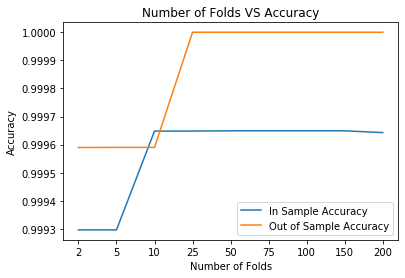

In [36]:
# Dataset 2 = mushroom 
#===========================

fold = [2,5,10,25,50,75,100,150,200]
a_train=[]
a_test=[]

for i in fold:
    acc_train, acc_test = cross_validation(mush_train_x, mush_train_y,mush_test_x, mush_test_y, 1, 100,5,1,3,'auto',i)
    a_train.append(statistics.mean(acc_train))
    a_test.append(statistics.mean(acc_test))
print(a_train)
print(a_test)

xi = list(range(len(fold)))
plt.title("Number of Folds VS Accuracy")
plt.xlabel("Number of Folds")
plt.ylabel("Accuracy")
plt.plot(a_train, label = 'In Sample Accuracy')
plt.plot(a_test, label = 'Out of Sample Accuracy')
plt.xticks(xi,fold)
plt.legend()
plt.show()

## Experiment with multiple samples of data

[0.86, 0.905, 0.915, 0.9176, 0.9205, 0.9207, 0.9214142857142857]
[0.85, 0.917, 0.9212, 0.9204, 0.9219999999999999, 0.92162, 0.9213428571428571]


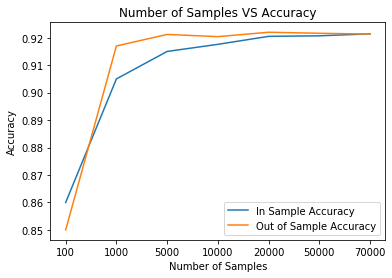

In [45]:
# Dataset 1 = sgemm product 
#===========================

fold = [100,1000,5000,10000,20000,50000,70000]
a_train=[]
a_test=[]

for i in fold:
    acc_train, acc_test = cross_validation(sgemm_train_x.head(i), sgemm_train_y.head(i), sgemm_test_x.head(i), sgemm_test_y.head(i), 1)
    a_train.append(statistics.mean(acc_train))
    a_test.append(statistics.mean(acc_test))
print(a_train)
print(a_test)

xi = list(range(len(fold)))
plt.title("Number of Samples VS Accuracy")
plt.xlabel("Number of Samples")
plt.ylabel("Accuracy")
plt.plot(a_train, label = 'In Sample Accuracy')
plt.plot(a_test, label = 'Out of Sample Accuracy')
plt.xticks(xi,fold)
plt.legend()
plt.show()

[0.94, 0.988, 0.995, 0.996, 0.9964999999999999, 0.9973913043478261]
[0.9199999999999999, 0.992, 0.998, 1.0, 0.998, 0.9995652173913043]


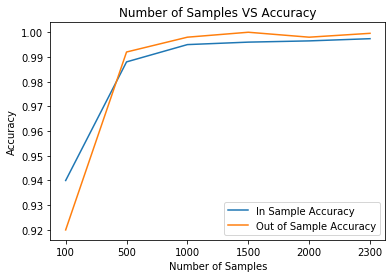

In [46]:
# Dataset 2 = mushroom 
#===========================

fold = [100,500,1000,1500,2000,2300]
a_train=[]
a_test=[]

for i in fold:
    acc_train, acc_test = cross_validation(mush_train_x.head(i), mush_train_y.head(i),mush_test_x.head(i), mush_test_y.head(i), 1)
    a_train.append(statistics.mean(acc_train))
    a_test.append(statistics.mean(acc_test))
print(a_train)
print(a_test)

xi = list(range(len(fold)))
plt.title("Number of Samples VS Accuracy")
plt.xlabel("Number of Samples")
plt.ylabel("Accuracy")
plt.plot(a_train, label = 'In Sample Accuracy')
plt.plot(a_test, label = 'Out of Sample Accuracy')
plt.xticks(xi,fold)
plt.legend()
plt.show()

# SVM using cross validation

0
Linear svm kernel
plotting in sample


C:\ProgramData\Anaconda3\lib\site-packages\mlxtend\plotting\decision_regions.py:247: UserWarning: No contour levels were found within the data range.
  antialiased=True)


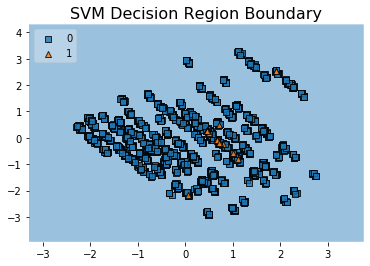

plotting out of sample


C:\ProgramData\Anaconda3\lib\site-packages\mlxtend\plotting\decision_regions.py:247: UserWarning: No contour levels were found within the data range.
  antialiased=True)


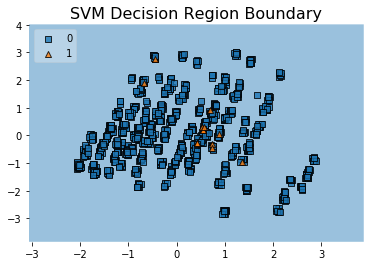

1
Linear svm kernel
plotting in sample


C:\ProgramData\Anaconda3\lib\site-packages\mlxtend\plotting\decision_regions.py:247: UserWarning: No contour levels were found within the data range.
  antialiased=True)


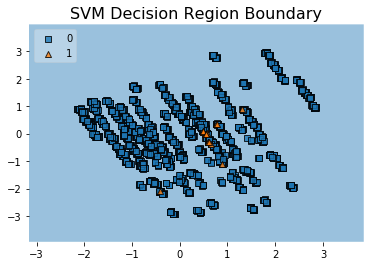

plotting out of sample


C:\ProgramData\Anaconda3\lib\site-packages\mlxtend\plotting\decision_regions.py:247: UserWarning: No contour levels were found within the data range.
  antialiased=True)


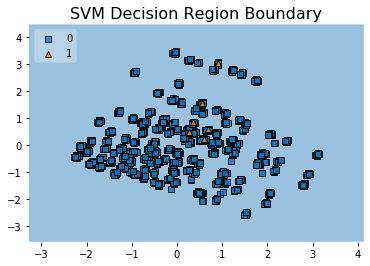

2
Linear svm kernel
plotting in sample


C:\ProgramData\Anaconda3\lib\site-packages\mlxtend\plotting\decision_regions.py:247: UserWarning: No contour levels were found within the data range.
  antialiased=True)


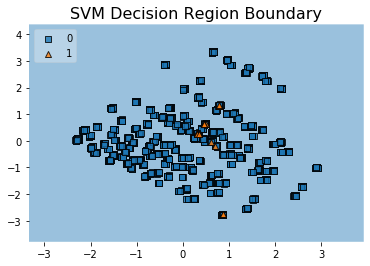

plotting out of sample


C:\ProgramData\Anaconda3\lib\site-packages\mlxtend\plotting\decision_regions.py:247: UserWarning: No contour levels were found within the data range.
  antialiased=True)


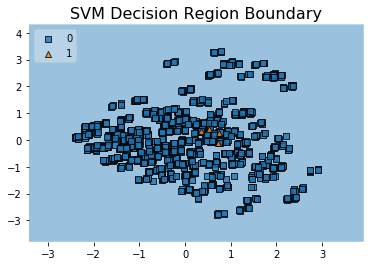

3
Linear svm kernel
plotting in sample


C:\ProgramData\Anaconda3\lib\site-packages\mlxtend\plotting\decision_regions.py:247: UserWarning: No contour levels were found within the data range.
  antialiased=True)


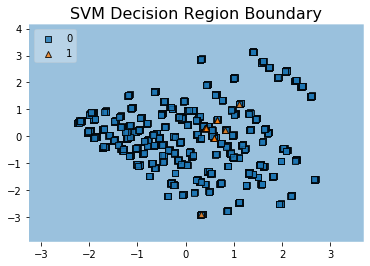

plotting out of sample


C:\ProgramData\Anaconda3\lib\site-packages\mlxtend\plotting\decision_regions.py:247: UserWarning: No contour levels were found within the data range.
  antialiased=True)


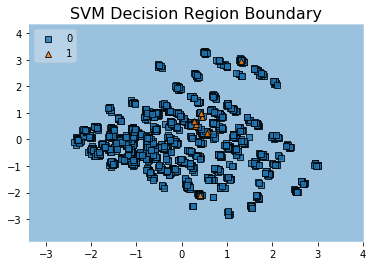

In Sample accuracy from svm - Linear Kernel is [0.9945714285714286, 0.9951428571428571, 0.9948571428571429, 0.9957142857142857]
Out of Sample accuracy from svm - Linear Kernel is [0.9913333333333333, 0.9946666666666667, 0.9973333333333333, 0.9933333333333333]
 
Average In Sample accuracy from svm - Linear Kernel is 0.9950714285714286
Average Out of Sample accuracy from svm - Linear Kernel is 0.9941666666666666
0
Polynomial svm kernel
plotting in sample


C:\ProgramData\Anaconda3\lib\site-packages\mlxtend\plotting\decision_regions.py:247: UserWarning: No contour levels were found within the data range.
  antialiased=True)


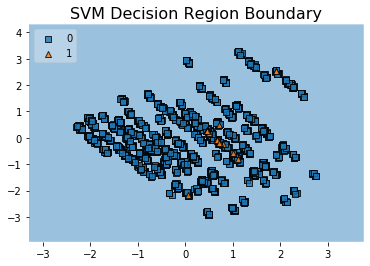

plotting out of sample


C:\ProgramData\Anaconda3\lib\site-packages\mlxtend\plotting\decision_regions.py:247: UserWarning: No contour levels were found within the data range.
  antialiased=True)


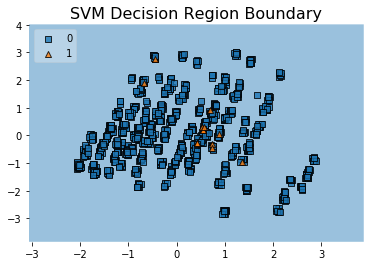

1
Polynomial svm kernel
plotting in sample


C:\ProgramData\Anaconda3\lib\site-packages\mlxtend\plotting\decision_regions.py:247: UserWarning: No contour levels were found within the data range.
  antialiased=True)


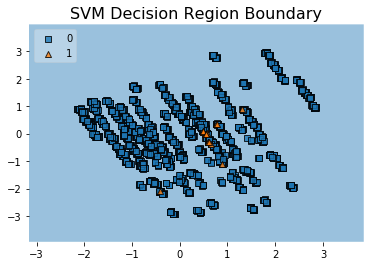

plotting out of sample


C:\ProgramData\Anaconda3\lib\site-packages\mlxtend\plotting\decision_regions.py:247: UserWarning: No contour levels were found within the data range.
  antialiased=True)


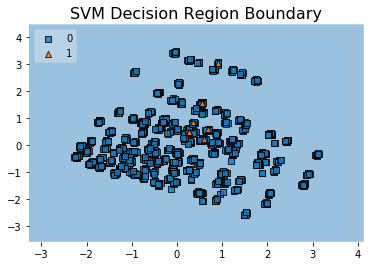

2
Polynomial svm kernel
plotting in sample


C:\ProgramData\Anaconda3\lib\site-packages\mlxtend\plotting\decision_regions.py:247: UserWarning: No contour levels were found within the data range.
  antialiased=True)


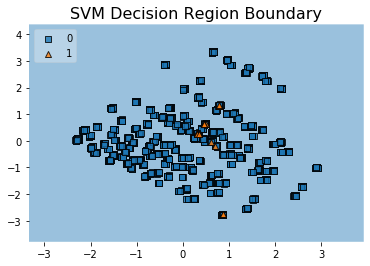

plotting out of sample


C:\ProgramData\Anaconda3\lib\site-packages\mlxtend\plotting\decision_regions.py:247: UserWarning: No contour levels were found within the data range.
  antialiased=True)


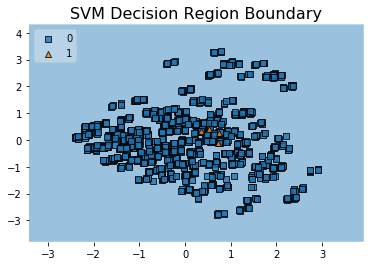

3
Polynomial svm kernel
plotting in sample


C:\ProgramData\Anaconda3\lib\site-packages\mlxtend\plotting\decision_regions.py:247: UserWarning: No contour levels were found within the data range.
  antialiased=True)


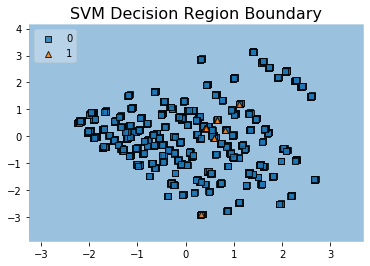

plotting out of sample


C:\ProgramData\Anaconda3\lib\site-packages\mlxtend\plotting\decision_regions.py:247: UserWarning: No contour levels were found within the data range.
  antialiased=True)


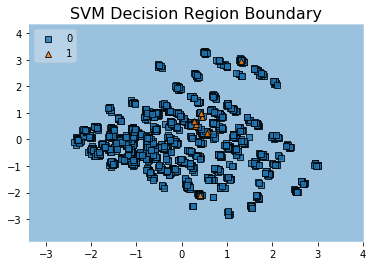

In Sample accuracy from svm - Polynomial Kernel is [0.9945714285714286, 0.9951428571428571, 0.9948571428571429, 0.9957142857142857]
Out of Sample accuracy from svm - Polynomial Kernel is [0.9913333333333333, 0.9946666666666667, 0.9973333333333333, 0.9933333333333333]
 
Average In Sample accuracy from svm - Polynomial Kernel is 0.9950714285714286
Average Out of Sample accuracy from svm - Polynomial Kernel is 0.9941666666666666
0
Radial Basis Function svm kernel
plotting in sample


C:\ProgramData\Anaconda3\lib\site-packages\mlxtend\plotting\decision_regions.py:247: UserWarning: No contour levels were found within the data range.
  antialiased=True)


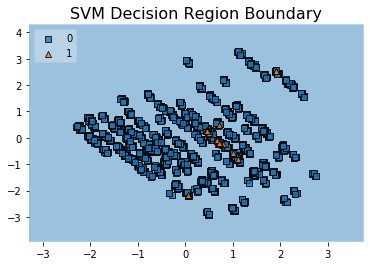

plotting out of sample


C:\ProgramData\Anaconda3\lib\site-packages\mlxtend\plotting\decision_regions.py:247: UserWarning: No contour levels were found within the data range.
  antialiased=True)


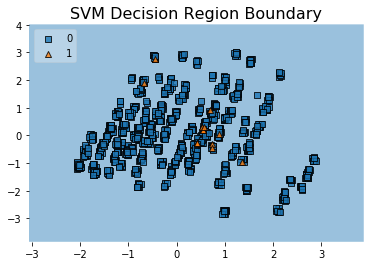

1
Radial Basis Function svm kernel
plotting in sample


C:\ProgramData\Anaconda3\lib\site-packages\mlxtend\plotting\decision_regions.py:247: UserWarning: No contour levels were found within the data range.
  antialiased=True)


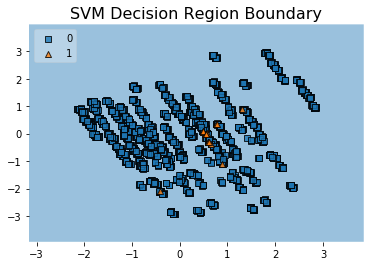

plotting out of sample


C:\ProgramData\Anaconda3\lib\site-packages\mlxtend\plotting\decision_regions.py:247: UserWarning: No contour levels were found within the data range.
  antialiased=True)


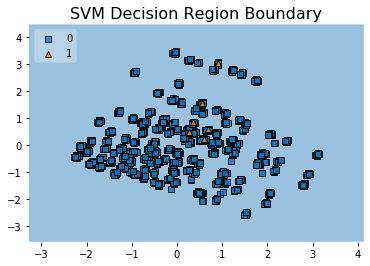

2
Radial Basis Function svm kernel
plotting in sample


C:\ProgramData\Anaconda3\lib\site-packages\mlxtend\plotting\decision_regions.py:247: UserWarning: No contour levels were found within the data range.
  antialiased=True)


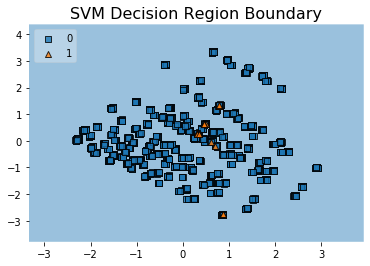

plotting out of sample


C:\ProgramData\Anaconda3\lib\site-packages\mlxtend\plotting\decision_regions.py:247: UserWarning: No contour levels were found within the data range.
  antialiased=True)


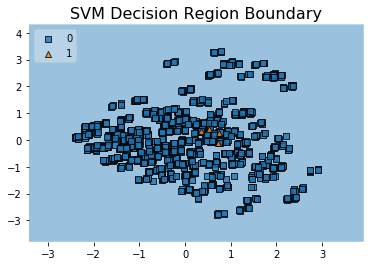

3
Radial Basis Function svm kernel
plotting in sample


C:\ProgramData\Anaconda3\lib\site-packages\mlxtend\plotting\decision_regions.py:247: UserWarning: No contour levels were found within the data range.
  antialiased=True)


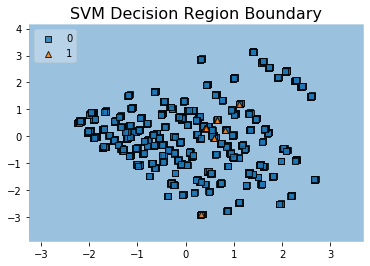

plotting out of sample


C:\ProgramData\Anaconda3\lib\site-packages\mlxtend\plotting\decision_regions.py:247: UserWarning: No contour levels were found within the data range.
  antialiased=True)


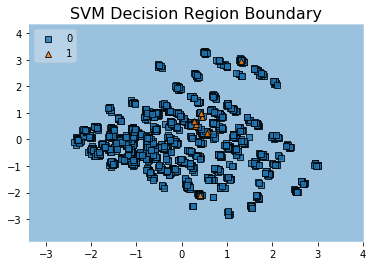

In Sample accuracy from svm - RBF Kernel is [0.9945714285714286, 0.9951428571428571, 0.9948571428571429, 0.9957142857142857]
Out of Sample accuracy from svm - RBF Kernel is [0.9913333333333333, 0.9946666666666667, 0.9973333333333333, 0.9933333333333333]
 
Average In Sample accuracy from svm - RBF Kernel is 0.9950714285714286
Average Out of Sample accuracy from svm - RBF Kernel is 0.9941666666666666


In [47]:
# Dataset 1 = sgemm product 
#===========================

SVM_accuracy_train,SVM_accuracy_test = cross_validation(sgemm_train_svm_x, sgemm_train_svm_y, sgemm_test_svm_x, sgemm_test_svm_y, 2)

print("In Sample accuracy from svm - Linear Kernel is {0}".format(SVM_accuracy_train))
print("Out of Sample accuracy from svm - Linear Kernel is {0}".format(SVM_accuracy_test))
print(" ")
print("Average In Sample accuracy from svm - Linear Kernel is {0}".format(statistics.mean(SVM_accuracy_train)))
print("Average Out of Sample accuracy from svm - Linear Kernel is {0}".format(statistics.mean(SVM_accuracy_test)))


SVM_accuracy_train,SVM_accuracy_test = cross_validation(sgemm_train_svm_x, sgemm_train_svm_y, sgemm_test_svm_x, sgemm_test_svm_y, 3)

print("In Sample accuracy from svm - Polynomial Kernel is {0}".format(SVM_accuracy_train))
print("Out of Sample accuracy from svm - Polynomial Kernel is {0}".format(SVM_accuracy_test))
print(" ")
print("Average In Sample accuracy from svm - Polynomial Kernel is {0}".format(statistics.mean(SVM_accuracy_train)))
print("Average Out of Sample accuracy from svm - Polynomial Kernel is {0}".format(statistics.mean(SVM_accuracy_test)))


SVM_accuracy_train,SVM_accuracy_test = cross_validation(sgemm_train_svm_x, sgemm_train_svm_y, sgemm_test_svm_x, sgemm_test_svm_y, 4)

print("In Sample accuracy from svm - RBF Kernel is {0}".format(SVM_accuracy_train))
print("Out of Sample accuracy from svm - RBF Kernel is {0}".format(SVM_accuracy_test))
print(" ")
print("Average In Sample accuracy from svm - RBF Kernel is {0}".format(statistics.mean(SVM_accuracy_train)))
print("Average Out of Sample accuracy from svm - RBF Kernel is {0}".format(statistics.mean(SVM_accuracy_test)))


0
Linear svm kernel
plotting in sample


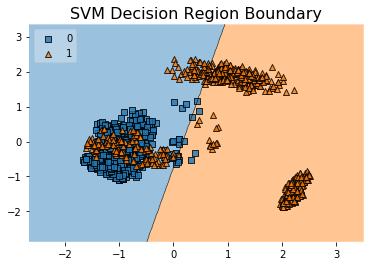

plotting out of sample


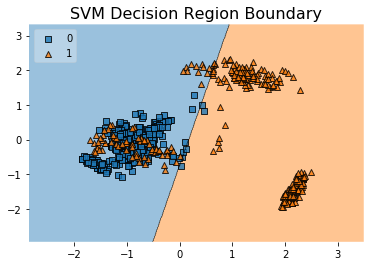

1
Linear svm kernel
plotting in sample


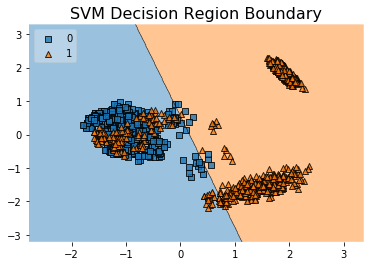

plotting out of sample


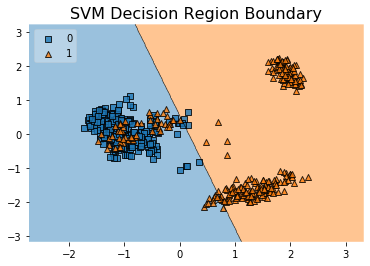

2
Linear svm kernel
plotting in sample


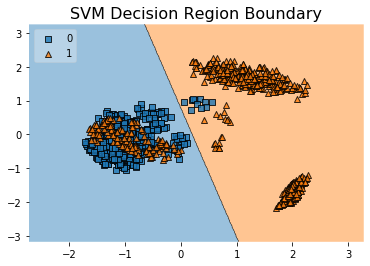

plotting out of sample


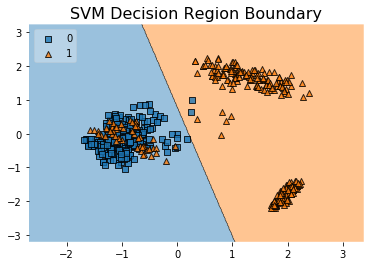

3
Linear svm kernel
plotting in sample


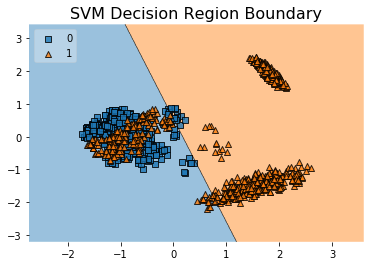

plotting out of sample


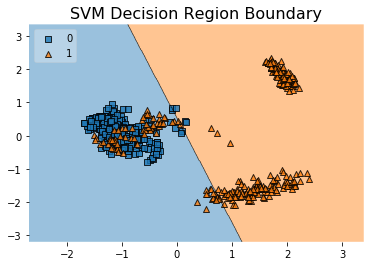

In Sample accuracy from svm - Linear Kernel is [1.0, 1.0, 1.0, 1.0]
Out of Sample accuracy from svm - Linear Kernel is [1.0, 1.0, 1.0, 1.0]
 
Average In Sample accuracy from svm - Linear Kernel is 1.0
Average Out of Sample accuracy from svm - Linear Kernel is 1.0
0
Polynomial svm kernel
plotting in sample


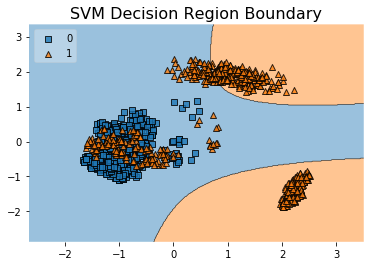

plotting out of sample


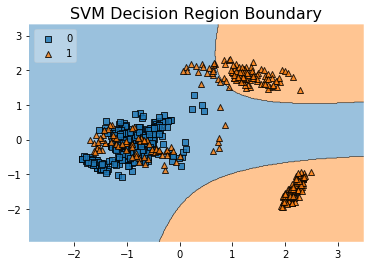

1
Polynomial svm kernel
plotting in sample


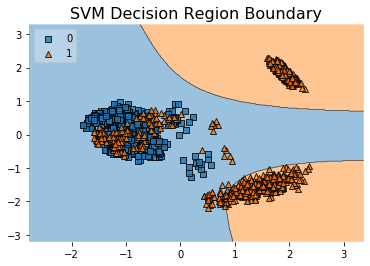

plotting out of sample


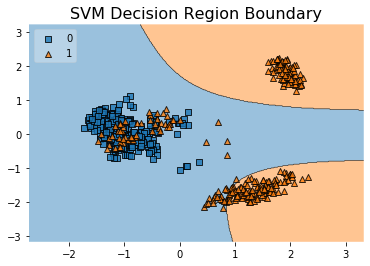

2
Polynomial svm kernel
plotting in sample


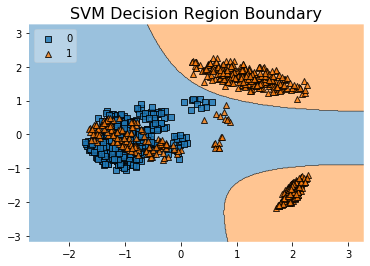

plotting out of sample


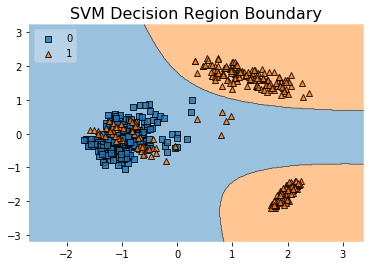

3
Polynomial svm kernel
plotting in sample


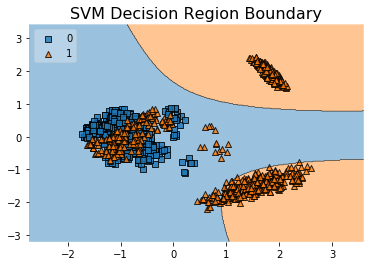

plotting out of sample


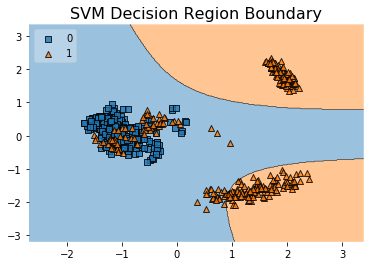

In Sample accuracy from svm - Polynomial Kernel is [0.9155524278676987, 0.9261603375527426, 0.9134412385643913, 0.9008438818565401]
Out of Sample accuracy from svm - Polynomial Kernel is [0.909688013136289, 0.940983606557377, 0.9178981937602627, 0.9278688524590164]
 
Average In Sample accuracy from svm - Polynomial Kernel is 0.9139994714603432
Average Out of Sample accuracy from svm - Polynomial Kernel is 0.9241096664782362
0
Radial Basis Function svm kernel
plotting in sample


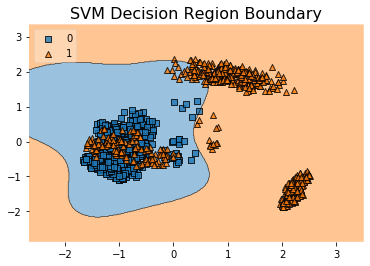

plotting out of sample


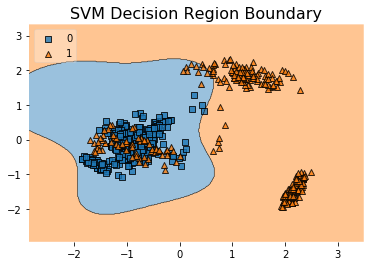

1
Radial Basis Function svm kernel
plotting in sample


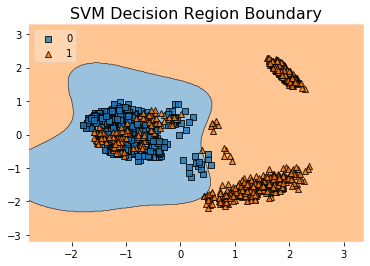

plotting out of sample


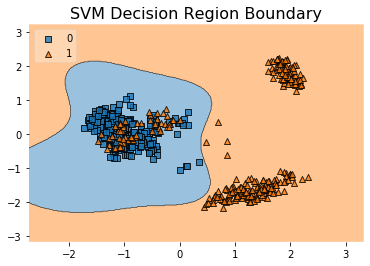

2
Radial Basis Function svm kernel
plotting in sample


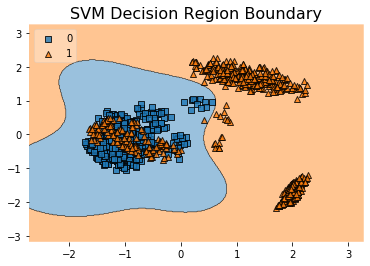

plotting out of sample


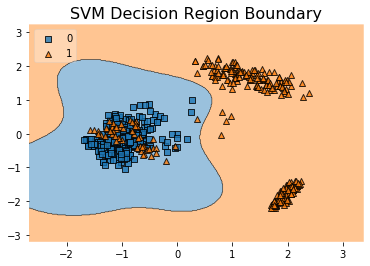

3
Radial Basis Function svm kernel
plotting in sample


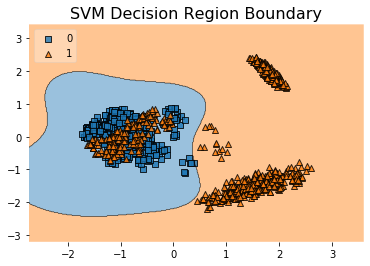

plotting out of sample


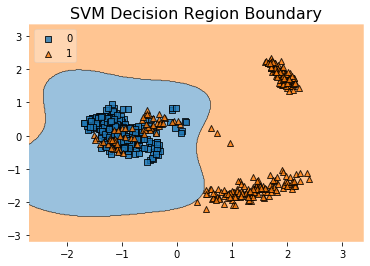

In Sample accuracy from svm - RBF Kernel is [0.9985925404644617, 0.9971870604781997, 0.9971850809289233, 0.9915611814345991]
Out of Sample accuracy from svm - RBF Kernel is [1.0, 0.9983606557377049, 0.9983579638752053, 0.9950819672131147]
 
Average In Sample accuracy from svm - RBF Kernel is 0.996131465826546
Average Out of Sample accuracy from svm - RBF Kernel is 0.9979501467065062


In [48]:
# Dataset 2 = mushroom
#===========================
# linear kernel
SVM_accuracy_train,SVM_accuracy_test = cross_validation(mush_train_x, mush_train_y,mush_test_x, mush_test_y, 2)

print("In Sample accuracy from svm - Linear Kernel is {0}".format(SVM_accuracy_train))
print("Out of Sample accuracy from svm - Linear Kernel is {0}".format(SVM_accuracy_test))
print(" ")
print("Average In Sample accuracy from svm - Linear Kernel is {0}".format(statistics.mean(SVM_accuracy_train)))
print("Average Out of Sample accuracy from svm - Linear Kernel is {0}".format(statistics.mean(SVM_accuracy_test)))


# Polynomial kernel
SVM_accuracy_train,SVM_accuracy_test = cross_validation(mush_train_x, mush_train_y,mush_test_x, mush_test_y, 3)

print("In Sample accuracy from svm - Polynomial Kernel is {0}".format(SVM_accuracy_train))
print("Out of Sample accuracy from svm - Polynomial Kernel is {0}".format(SVM_accuracy_test))
print(" ")
print("Average In Sample accuracy from svm - Polynomial Kernel is {0}".format(statistics.mean(SVM_accuracy_train)))
print("Average Out of Sample accuracy from svm - Polynomial Kernel is {0}".format(statistics.mean(SVM_accuracy_test)))


# rbf kernel
SVM_accuracy_train,SVM_accuracy_test = cross_validation(mush_train_x, mush_train_y,mush_test_x, mush_test_y, 4)

print("In Sample accuracy from svm - RBF Kernel is {0}".format(SVM_accuracy_train))
print("Out of Sample accuracy from svm - RBF Kernel is {0}".format(SVM_accuracy_test))
print(" ")
print("Average In Sample accuracy from svm - RBF Kernel is {0}".format(statistics.mean(SVM_accuracy_train)))
print("Average Out of Sample accuracy from svm - RBF Kernel is {0}".format(statistics.mean(SVM_accuracy_test)))


### Experiment with different C

### Linear Kernel

0
Linear svm kernel
plotting in sample


C:\ProgramData\Anaconda3\lib\site-packages\mlxtend\plotting\decision_regions.py:247: UserWarning: No contour levels were found within the data range.
  antialiased=True)


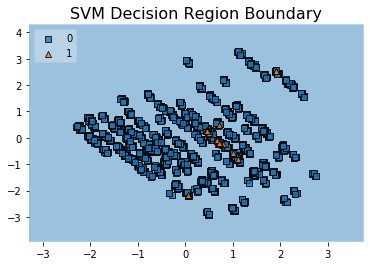

plotting out of sample


C:\ProgramData\Anaconda3\lib\site-packages\mlxtend\plotting\decision_regions.py:247: UserWarning: No contour levels were found within the data range.
  antialiased=True)


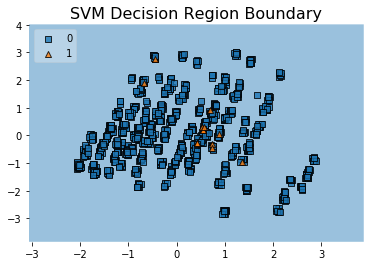

1
Linear svm kernel
plotting in sample


C:\ProgramData\Anaconda3\lib\site-packages\mlxtend\plotting\decision_regions.py:247: UserWarning: No contour levels were found within the data range.
  antialiased=True)


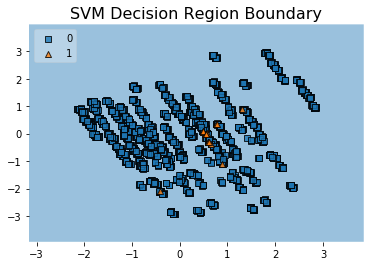

plotting out of sample


C:\ProgramData\Anaconda3\lib\site-packages\mlxtend\plotting\decision_regions.py:247: UserWarning: No contour levels were found within the data range.
  antialiased=True)


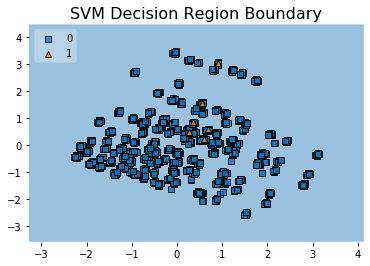

2
Linear svm kernel
plotting in sample


C:\ProgramData\Anaconda3\lib\site-packages\mlxtend\plotting\decision_regions.py:247: UserWarning: No contour levels were found within the data range.
  antialiased=True)


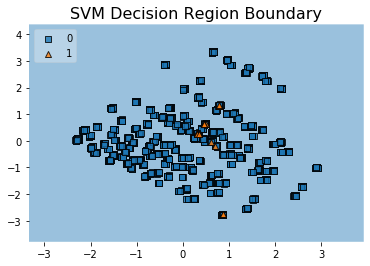

plotting out of sample


C:\ProgramData\Anaconda3\lib\site-packages\mlxtend\plotting\decision_regions.py:247: UserWarning: No contour levels were found within the data range.
  antialiased=True)


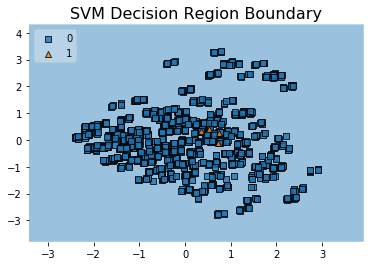

3
Linear svm kernel
plotting in sample


C:\ProgramData\Anaconda3\lib\site-packages\mlxtend\plotting\decision_regions.py:247: UserWarning: No contour levels were found within the data range.
  antialiased=True)


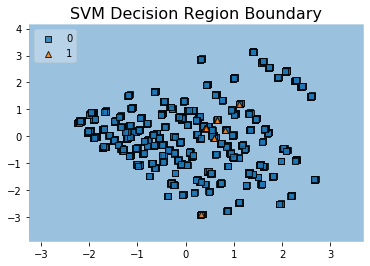

plotting out of sample


C:\ProgramData\Anaconda3\lib\site-packages\mlxtend\plotting\decision_regions.py:247: UserWarning: No contour levels were found within the data range.
  antialiased=True)


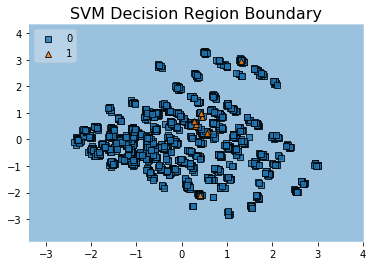

0
Linear svm kernel
plotting in sample


C:\ProgramData\Anaconda3\lib\site-packages\mlxtend\plotting\decision_regions.py:247: UserWarning: No contour levels were found within the data range.
  antialiased=True)


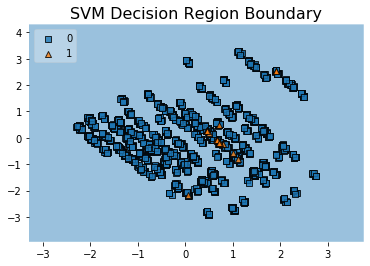

plotting out of sample


C:\ProgramData\Anaconda3\lib\site-packages\mlxtend\plotting\decision_regions.py:247: UserWarning: No contour levels were found within the data range.
  antialiased=True)


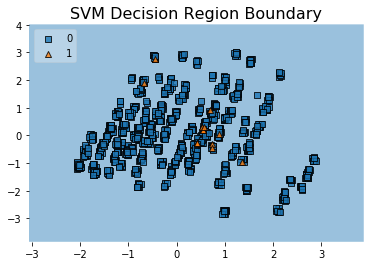

1
Linear svm kernel
plotting in sample


C:\ProgramData\Anaconda3\lib\site-packages\mlxtend\plotting\decision_regions.py:247: UserWarning: No contour levels were found within the data range.
  antialiased=True)


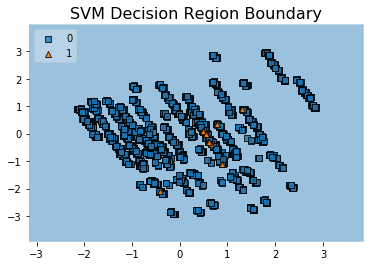

plotting out of sample


C:\ProgramData\Anaconda3\lib\site-packages\mlxtend\plotting\decision_regions.py:247: UserWarning: No contour levels were found within the data range.
  antialiased=True)


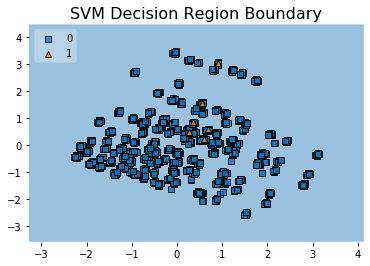

2
Linear svm kernel
plotting in sample


C:\ProgramData\Anaconda3\lib\site-packages\mlxtend\plotting\decision_regions.py:247: UserWarning: No contour levels were found within the data range.
  antialiased=True)


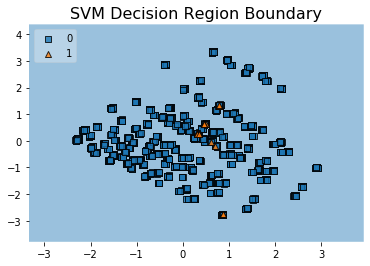

plotting out of sample


C:\ProgramData\Anaconda3\lib\site-packages\mlxtend\plotting\decision_regions.py:247: UserWarning: No contour levels were found within the data range.
  antialiased=True)


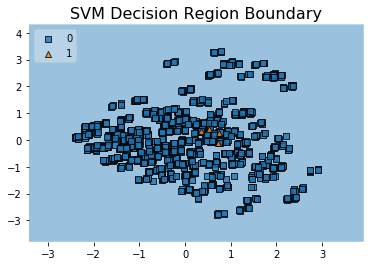

3
Linear svm kernel
plotting in sample


C:\ProgramData\Anaconda3\lib\site-packages\mlxtend\plotting\decision_regions.py:247: UserWarning: No contour levels were found within the data range.
  antialiased=True)


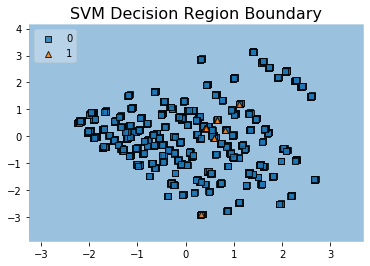

plotting out of sample


C:\ProgramData\Anaconda3\lib\site-packages\mlxtend\plotting\decision_regions.py:247: UserWarning: No contour levels were found within the data range.
  antialiased=True)


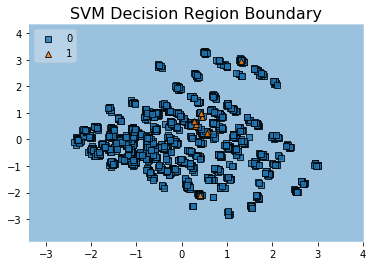

0
Linear svm kernel
plotting in sample


C:\ProgramData\Anaconda3\lib\site-packages\mlxtend\plotting\decision_regions.py:247: UserWarning: No contour levels were found within the data range.
  antialiased=True)


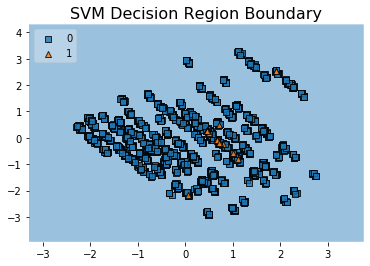

plotting out of sample


C:\ProgramData\Anaconda3\lib\site-packages\mlxtend\plotting\decision_regions.py:247: UserWarning: No contour levels were found within the data range.
  antialiased=True)


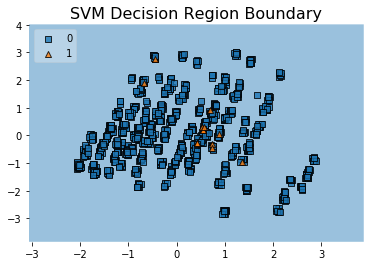

1
Linear svm kernel
plotting in sample


C:\ProgramData\Anaconda3\lib\site-packages\mlxtend\plotting\decision_regions.py:247: UserWarning: No contour levels were found within the data range.
  antialiased=True)


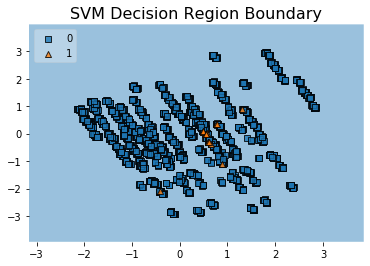

plotting out of sample


C:\ProgramData\Anaconda3\lib\site-packages\mlxtend\plotting\decision_regions.py:247: UserWarning: No contour levels were found within the data range.
  antialiased=True)


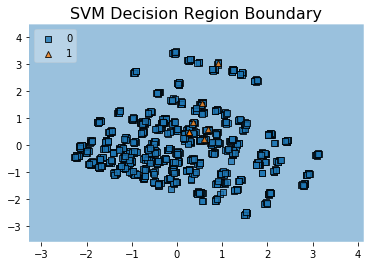

2
Linear svm kernel
plotting in sample


C:\ProgramData\Anaconda3\lib\site-packages\mlxtend\plotting\decision_regions.py:247: UserWarning: No contour levels were found within the data range.
  antialiased=True)


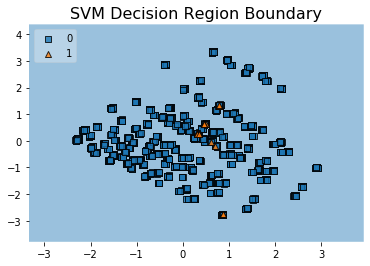

plotting out of sample


C:\ProgramData\Anaconda3\lib\site-packages\mlxtend\plotting\decision_regions.py:247: UserWarning: No contour levels were found within the data range.
  antialiased=True)


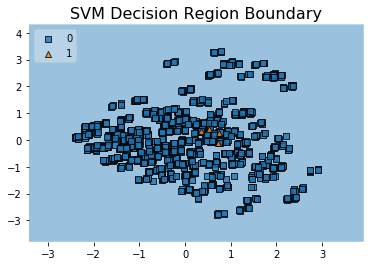

3
Linear svm kernel
plotting in sample


C:\ProgramData\Anaconda3\lib\site-packages\mlxtend\plotting\decision_regions.py:247: UserWarning: No contour levels were found within the data range.
  antialiased=True)


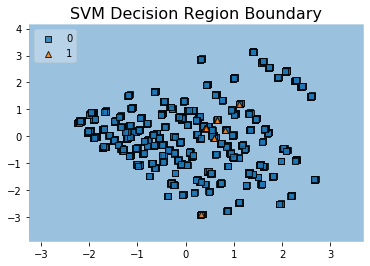

plotting out of sample


C:\ProgramData\Anaconda3\lib\site-packages\mlxtend\plotting\decision_regions.py:247: UserWarning: No contour levels were found within the data range.
  antialiased=True)


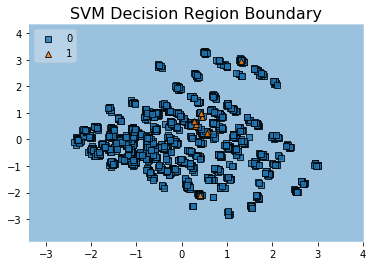

0
Linear svm kernel
plotting in sample


C:\ProgramData\Anaconda3\lib\site-packages\mlxtend\plotting\decision_regions.py:247: UserWarning: No contour levels were found within the data range.
  antialiased=True)


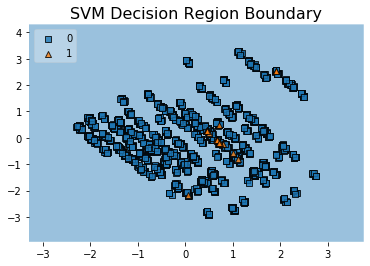

plotting out of sample


C:\ProgramData\Anaconda3\lib\site-packages\mlxtend\plotting\decision_regions.py:247: UserWarning: No contour levels were found within the data range.
  antialiased=True)


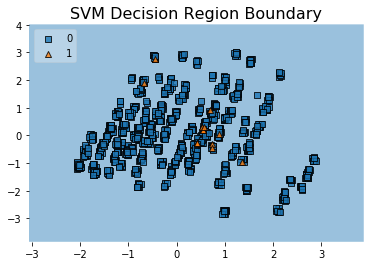

1
Linear svm kernel
plotting in sample


C:\ProgramData\Anaconda3\lib\site-packages\mlxtend\plotting\decision_regions.py:247: UserWarning: No contour levels were found within the data range.
  antialiased=True)


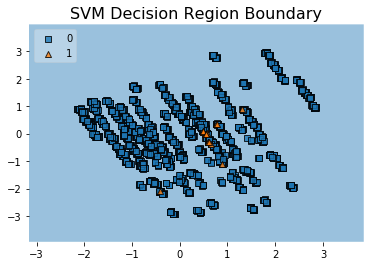

plotting out of sample


C:\ProgramData\Anaconda3\lib\site-packages\mlxtend\plotting\decision_regions.py:247: UserWarning: No contour levels were found within the data range.
  antialiased=True)


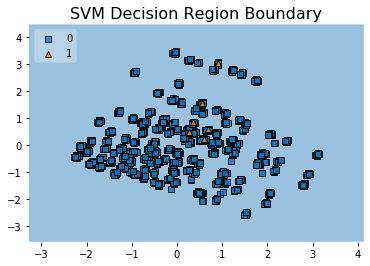

2
Linear svm kernel
plotting in sample


C:\ProgramData\Anaconda3\lib\site-packages\mlxtend\plotting\decision_regions.py:247: UserWarning: No contour levels were found within the data range.
  antialiased=True)


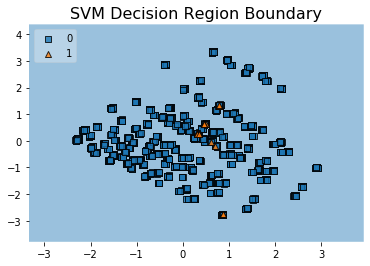

plotting out of sample


C:\ProgramData\Anaconda3\lib\site-packages\mlxtend\plotting\decision_regions.py:247: UserWarning: No contour levels were found within the data range.
  antialiased=True)


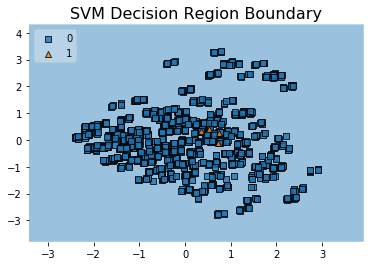

3
Linear svm kernel
plotting in sample


C:\ProgramData\Anaconda3\lib\site-packages\mlxtend\plotting\decision_regions.py:247: UserWarning: No contour levels were found within the data range.
  antialiased=True)


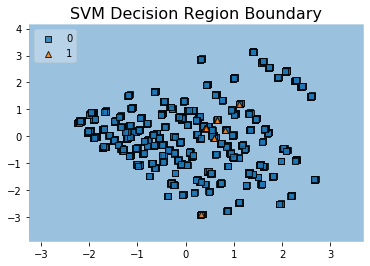

plotting out of sample


C:\ProgramData\Anaconda3\lib\site-packages\mlxtend\plotting\decision_regions.py:247: UserWarning: No contour levels were found within the data range.
  antialiased=True)


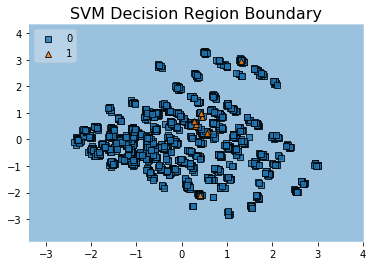

0
Linear svm kernel
plotting in sample


C:\ProgramData\Anaconda3\lib\site-packages\mlxtend\plotting\decision_regions.py:247: UserWarning: No contour levels were found within the data range.
  antialiased=True)


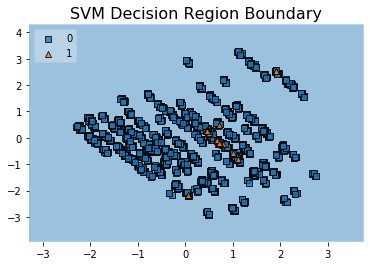

plotting out of sample


C:\ProgramData\Anaconda3\lib\site-packages\mlxtend\plotting\decision_regions.py:247: UserWarning: No contour levels were found within the data range.
  antialiased=True)


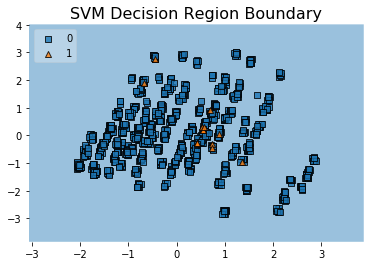

1
Linear svm kernel
plotting in sample


C:\ProgramData\Anaconda3\lib\site-packages\mlxtend\plotting\decision_regions.py:247: UserWarning: No contour levels were found within the data range.
  antialiased=True)


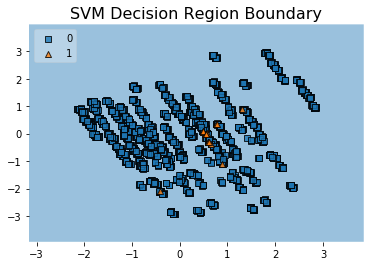

plotting out of sample


C:\ProgramData\Anaconda3\lib\site-packages\mlxtend\plotting\decision_regions.py:247: UserWarning: No contour levels were found within the data range.
  antialiased=True)


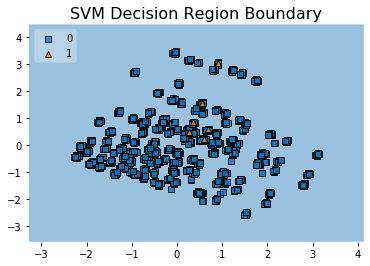

2
Linear svm kernel
plotting in sample


C:\ProgramData\Anaconda3\lib\site-packages\mlxtend\plotting\decision_regions.py:247: UserWarning: No contour levels were found within the data range.
  antialiased=True)


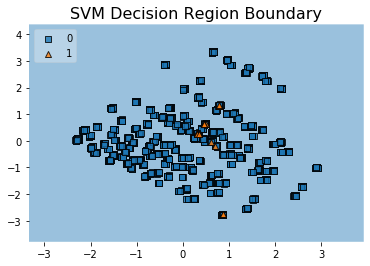

plotting out of sample


C:\ProgramData\Anaconda3\lib\site-packages\mlxtend\plotting\decision_regions.py:247: UserWarning: No contour levels were found within the data range.
  antialiased=True)


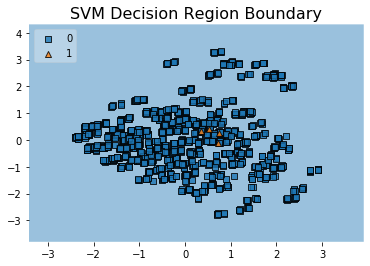

3
Linear svm kernel
plotting in sample


C:\ProgramData\Anaconda3\lib\site-packages\mlxtend\plotting\decision_regions.py:247: UserWarning: No contour levels were found within the data range.
  antialiased=True)


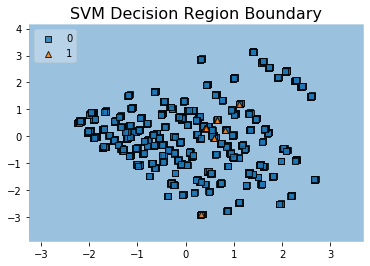

plotting out of sample


C:\ProgramData\Anaconda3\lib\site-packages\mlxtend\plotting\decision_regions.py:247: UserWarning: No contour levels were found within the data range.
  antialiased=True)


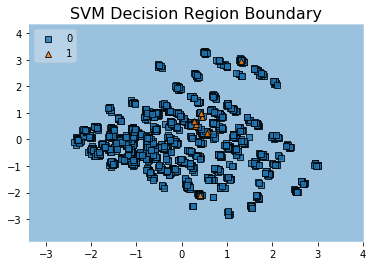

In Sample accuracy from svm - Linear Kernel is [0.9950714285714286, 0.9950714285714286, 0.9950714285714286, 0.9950714285714286, 0.9950714285714286]
Out of Sample accuracy from svm - Linear Kernel is [0.9941666666666666, 0.9941666666666666, 0.9941666666666666, 0.9941666666666666, 0.9941666666666666]


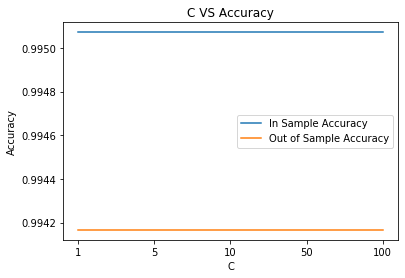

In [49]:
# Dataset 1 = sgemm product 
#===========================

c_list = [1, 5, 10, 50, 100]
a_train =[]
a_test = []

for i in c_list:
    SVM_accuracy_train,SVM_accuracy_test = cross_validation(sgemm_train_svm_x, sgemm_train_svm_y, sgemm_test_svm_x, sgemm_test_svm_y, 2, 10,5, i)
    a_train.append(statistics.mean(SVM_accuracy_train))
    a_test.append(statistics.mean(SVM_accuracy_test))
        
print("In Sample accuracy from svm - Linear Kernel is {0}".format(a_train))
print("Out of Sample accuracy from svm - Linear Kernel is {0}".format(a_test))

xi = list(range(len(c_list)))
plt.title("C VS Accuracy")
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.plot(a_train, label = 'In Sample Accuracy')
plt.plot(a_test, label = 'Out of Sample Accuracy')
plt.xticks(xi,c_list)
plt.legend()
plt.show()

0
Linear svm kernel
plotting in sample


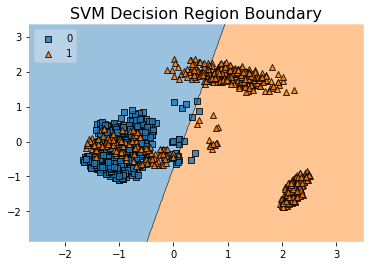

plotting out of sample


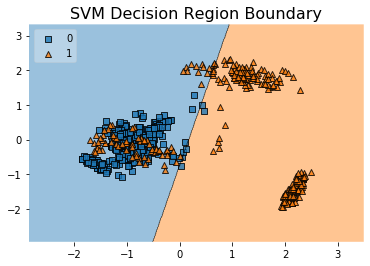

1
Linear svm kernel
plotting in sample


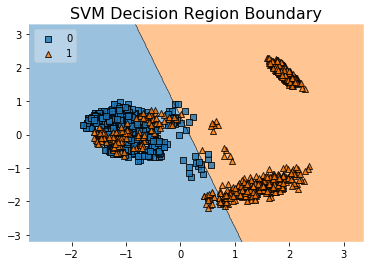

plotting out of sample


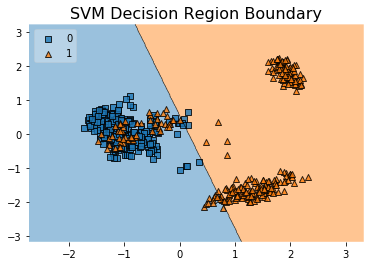

2
Linear svm kernel
plotting in sample


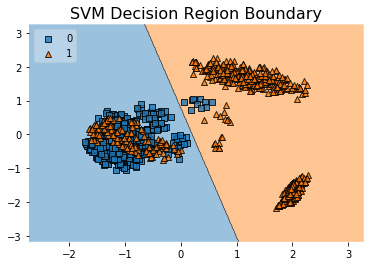

plotting out of sample


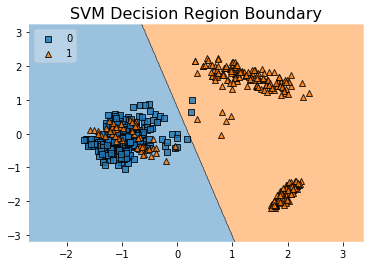

3
Linear svm kernel
plotting in sample


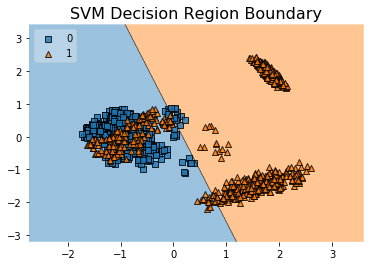

plotting out of sample


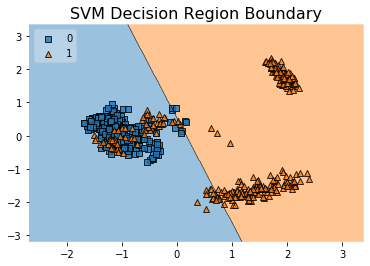

0
Linear svm kernel
plotting in sample


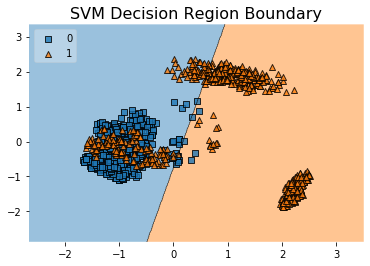

plotting out of sample


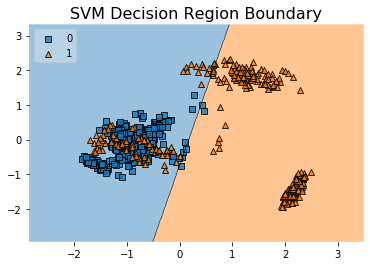

1
Linear svm kernel
plotting in sample


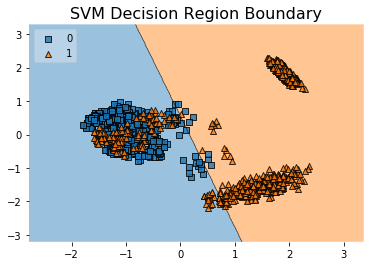

plotting out of sample


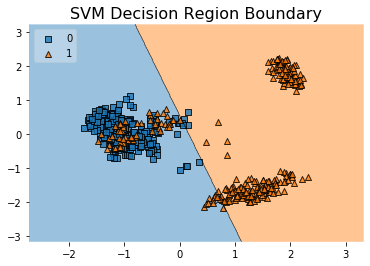

2
Linear svm kernel
plotting in sample


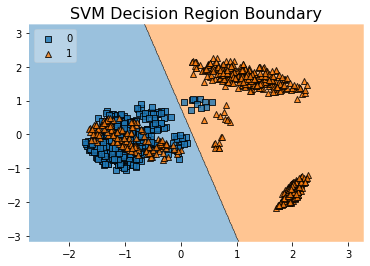

plotting out of sample


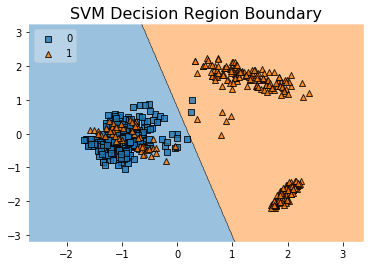

3
Linear svm kernel
plotting in sample


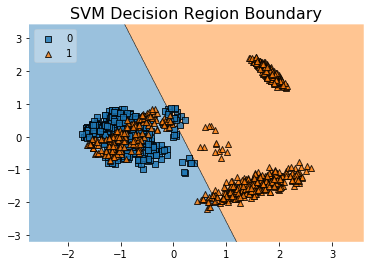

plotting out of sample


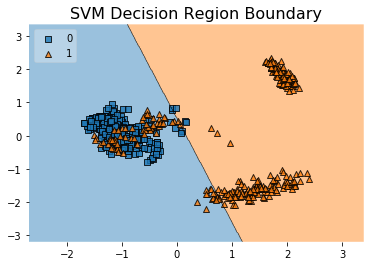

0
Linear svm kernel
plotting in sample


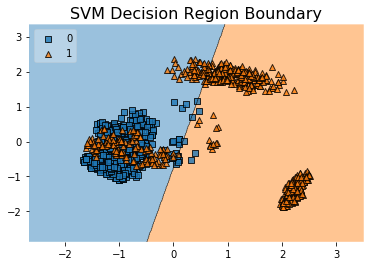

plotting out of sample


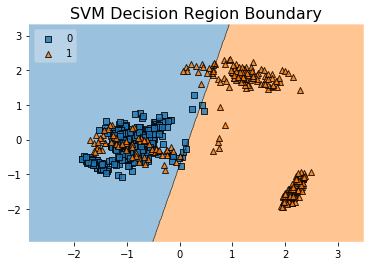

1
Linear svm kernel
plotting in sample


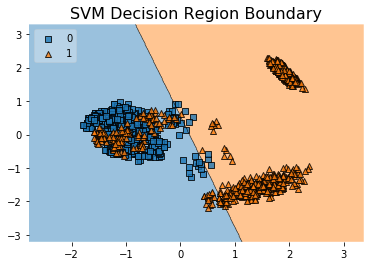

plotting out of sample


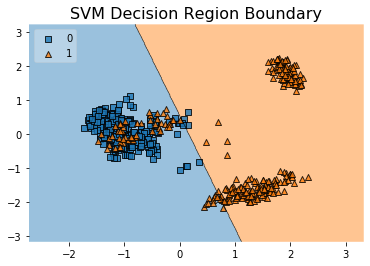

2
Linear svm kernel
plotting in sample


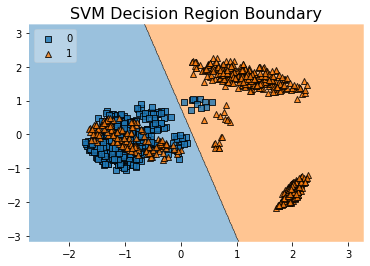

plotting out of sample


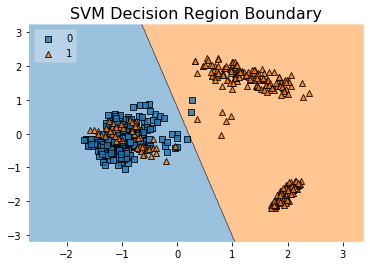

3
Linear svm kernel
plotting in sample


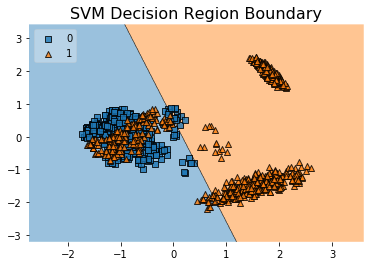

plotting out of sample


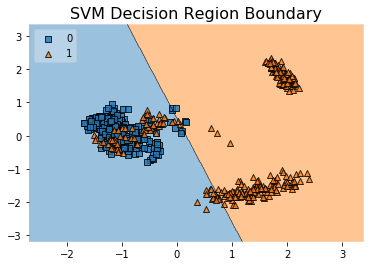

0
Linear svm kernel
plotting in sample


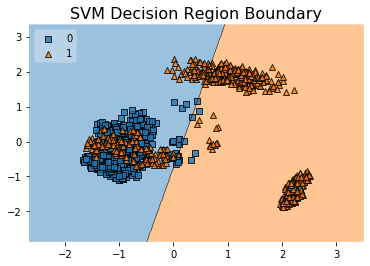

plotting out of sample


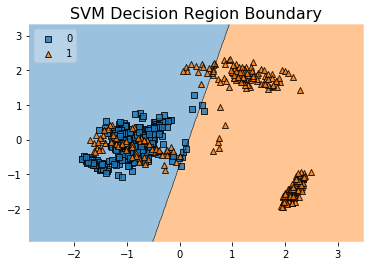

1
Linear svm kernel
plotting in sample


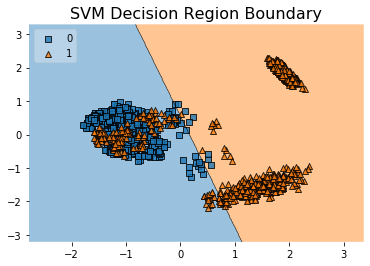

plotting out of sample


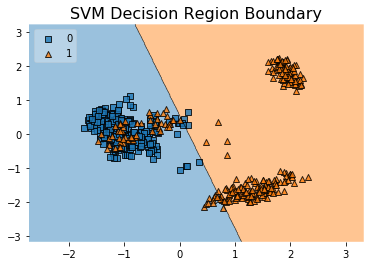

2
Linear svm kernel
plotting in sample


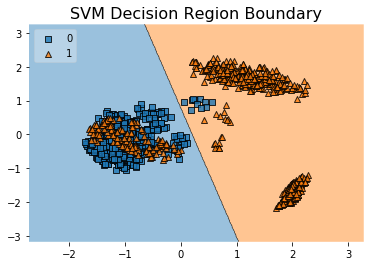

plotting out of sample


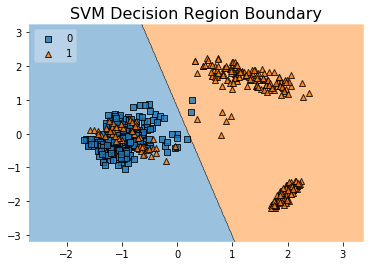

3
Linear svm kernel
plotting in sample


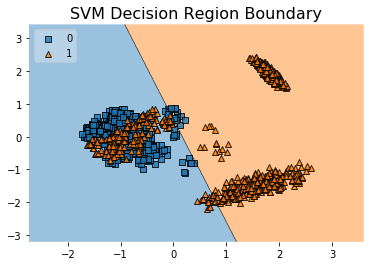

plotting out of sample


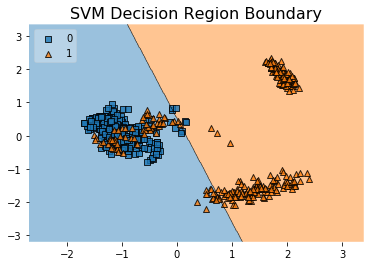

0
Linear svm kernel
plotting in sample


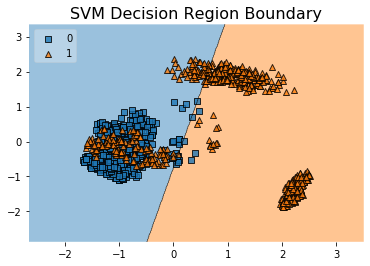

plotting out of sample


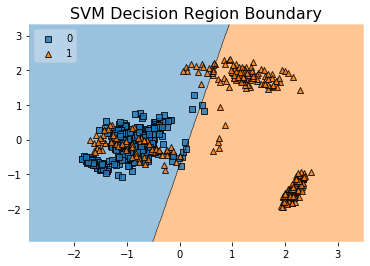

1
Linear svm kernel
plotting in sample


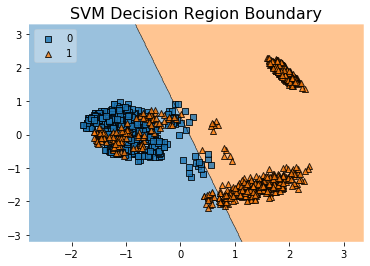

plotting out of sample


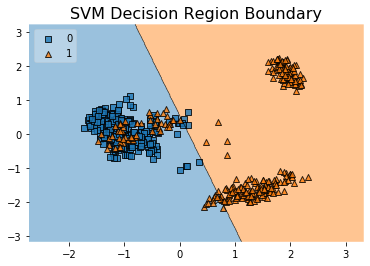

2
Linear svm kernel
plotting in sample


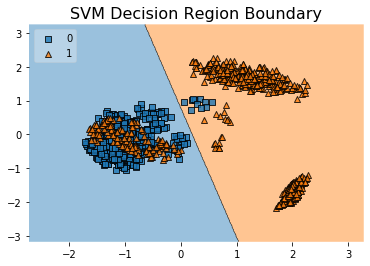

plotting out of sample


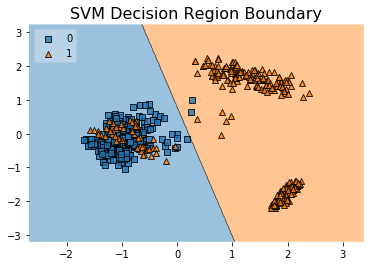

3
Linear svm kernel
plotting in sample


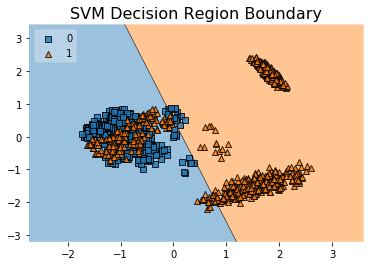

plotting out of sample


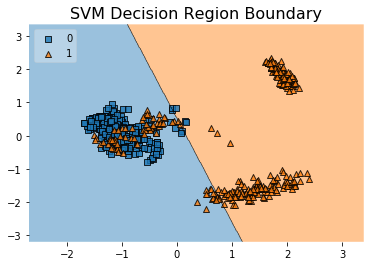

In Sample accuracy from svm - Linear Kernel is [1.0, 1.0, 1.0, 1.0, 1.0]
Out of Sample accuracy from svm - Linear Kernel is [1.0, 1.0, 1.0, 1.0, 1.0]


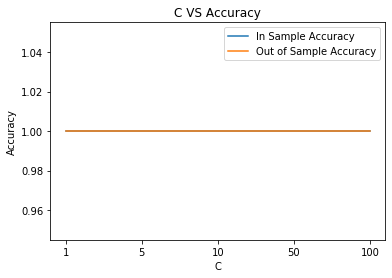

In [50]:
# Dataset 2 = mushroom
#===========================
c_list = [1, 5, 10, 50, 100]
a_train =[]
a_test = []

for i in c_list:
    SVM_accuracy_train,SVM_accuracy_test = cross_validation(mush_train_x, mush_train_y,mush_test_x, mush_test_y, 2, 10,5, i)
    a_train.append(statistics.mean(SVM_accuracy_train))
    a_test.append(statistics.mean(SVM_accuracy_test))
        
print("In Sample accuracy from svm - Linear Kernel is {0}".format(a_train))
print("Out of Sample accuracy from svm - Linear Kernel is {0}".format(a_test))

xi = list(range(len(c_list)))
plt.title("C VS Accuracy")
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.plot(a_train, label = 'In Sample Accuracy')
plt.plot(a_test, label = 'Out of Sample Accuracy')
plt.xticks(xi,c_list)
plt.legend()
plt.show()

In [212]:
tuned_param = {'C': [1, 10, 100,500, 1000], 'kernel': ['linear','rbf'], 'C': [1, 10, 100,500, 1000], 'gamma': [1,0.1,0.01,0.001, 0.0001], 'kernel': ['rbf']}
clf= SVC()
model = RandomizedSearchCV(clf, tuned_param,cv=4,scoring='accuracy',n_iter=10)
model.fit(sgemm_train_svm_x, sgemm_train_svm_y)
print(model.best_score_)
print(model.best_params_)

0.9985
{'kernel': 'rbf', 'gamma': 0.1, 'C': 10}


In [208]:
tuned_param = {'C': [1, 10, 100,500, 1000], 'kernel': ['linear','rbf'], 'C': [1, 10, 100,500, 1000], 'gamma': [1,0.1,0.01,0.001, 0.0001], 'kernel': ['rbf']}
clf= SVC()
model = RandomizedSearchCV(clf, tuned_param,cv=4,scoring='accuracy',n_iter=10)
model.fit(mush_train_x, mush_train_y)
print(model.best_score_)
print(model.best_params_)

1.0
{'kernel': 'rbf', 'gamma': 0.1, 'C': 1000}


In [211]:
tuned_param = {'C': [1, 10, 100,500, 1000], 'kernel': ['linear','rbf'], 'C': [1, 10, 100,500, 1000], 'gamma': [1,0.1,0.01,0.001, 0.0001], 'kernel': ['rbf'], 'degree': [2,3,4,5,6] , 'C':[1,10,100,500,1000] , 'kernel':['poly']}
clf= SVC()
model = RandomizedSearchCV(clf, tuned_param,cv=4,scoring='accuracy',n_iter=10)
model.fit(sgemm_train_svm_x, sgemm_train_svm_y)
print(model.best_score_)
print(model.best_params_)

0.9986428571428572
{'kernel': 'poly', 'gamma': 1, 'degree': 3, 'C': 500}


In [210]:
tuned_param = {'C': [1, 10, 100,500, 1000], 'kernel': ['linear','rbf'], 'C': [1, 10, 100,500, 1000], 'gamma': [1,0.1,0.01,0.001, 0.0001], 'kernel': ['rbf'], 'degree': [2,3,4,5,6] , 'C':[1,10,100,500,1000] , 'kernel':['poly']}
clf= SVC()
model = RandomizedSearchCV(clf, tuned_param,cv=4,scoring='accuracy',n_iter=10)
model.fit(mush_train_x, mush_train_y)
print(model.best_score_)
print(model.best_params_)

1.0
{'kernel': 'poly', 'gamma': 1, 'degree': 2, 'C': 1000}


# Fully grown Decision Tree using cross validation

### Using GINI Index

In [29]:
# Dataset 1 = sgemm product 
#===========================

acc_train, acc_test = cross_validation(sgemm_train_x, sgemm_train_y, sgemm_test_x, sgemm_test_y, 5)

print("In Sample accuracy from Decision Tree with Gini Index is {0}".format(acc_train))
print("Out of Sample accuracy from Decision Tree with Gini Index is {0}".format(acc_test))
print(" ")
print("Average In Sample accuracy from Decision Tree with Gini Index is {0}".format(statistics.mean(acc_train)))
print("Average Out of Sample accuracy from Decision Tree with Gini Index is {0}".format(statistics.mean(acc_test)))


In Sample accuracy from Decision Tree with Gini Index is [0.9939556587123135, 0.9940281908077657, 0.9939798360774643, 0.9947293343971374]
Out of Sample accuracy from Decision Tree with Gini Index is [0.9941893264131784, 0.9941893264131784, 0.9942457407198465, 0.9935691318327974]
 
Average In Sample accuracy from Decision Tree with Gini Index is 0.9941732549986703
Average Out of Sample accuracy from Decision Tree with Gini Index is 0.9940483813447502


In [30]:
# Dataset 2 = mushroom
#======================

acc_train, acc_test = cross_validation(mush_train_x, mush_train_y,mush_test_x, mush_test_y, 5)

print("In Sample accuracy from Decision Tree with Gini Index is {0}".format(acc_train))
print("Out of Sample accuracy from Decision Tree with Gini Index is {0}".format(acc_test))
print(" ")
print("Average In Sample accuracy from Decision Tree with Gini Index is {0}".format(statistics.mean(acc_train)))
print("Average Out of Sample accuracy from Decision Tree with Gini Index is {0}".format(statistics.mean(acc_test)))


In Sample accuracy from Decision Tree with Gini Index is [1.0, 1.0, 1.0, 0.9992967651195499]
Out of Sample accuracy from Decision Tree with Gini Index is [1.0, 1.0, 1.0, 0.9983606557377049]
 
Average In Sample accuracy from Decision Tree with Gini Index is 0.9998241912798875
Average Out of Sample accuracy from Decision Tree with Gini Index is 0.9995901639344262


### Using Entropy

In [31]:
# Dataset 1 = sgemm product 
#===========================

acc_train, acc_test = cross_validation(sgemm_train_x, sgemm_train_y, sgemm_test_x, sgemm_test_y, 6)

print("In Sample accuracy from Decision Tree with Entropy is {0}".format(acc_train))
print("Out of Sample accuracy from Decision Tree with Entropy is {0}".format(acc_test))
print(" ")
print("Average In Sample accuracy from Decision Tree with Entropy is {0}".format(statistics.mean(acc_train)))
print("Average Out of Sample accuracy from Decision Tree with Entropy is {0}".format(statistics.mean(acc_test)))

In Sample accuracy from Decision Tree with Entropy is [0.9937622397911076, 0.9937380624259569, 0.9943908512850269, 0.9947535117622881]
Out of Sample accuracy from Decision Tree with Entropy is [0.9944713979465193, 0.9931174545864832, 0.9943021550265148, 0.9931742539628815]
 
Average In Sample accuracy from Decision Tree with Entropy is 0.9941611663160949
Average Out of Sample accuracy from Decision Tree with Entropy is 0.9937663153805997


In [32]:
# Dataset 2 = mushroom
#======================

acc_train, acc_test = cross_validation(mush_train_x, mush_train_y,mush_test_x, mush_test_y, 6)

print("In Sample accuracy from Decision Tree with Entropy is {0}".format(acc_train))
print("Out of Sample accuracy from Decision Tree with Entropy is {0}".format(acc_test))
print(" ")
print("Average In Sample accuracy from Decision Tree with Entropy is {0}".format(statistics.mean(acc_train)))
print("Average Out of Sample accuracy from Decision Tree with Entropy is {0}".format(statistics.mean(acc_test)))


In Sample accuracy from Decision Tree with Entropy is [1.0, 1.0, 1.0, 0.9992967651195499]
Out of Sample accuracy from Decision Tree with Entropy is [1.0, 1.0, 1.0, 0.9983606557377049]
 
Average In Sample accuracy from Decision Tree with Entropy is 0.9998241912798875
Average Out of Sample accuracy from Decision Tree with Entropy is 0.9995901639344262


## Plotting ROC Curve to determine which one to use - Gini Index or Entropy

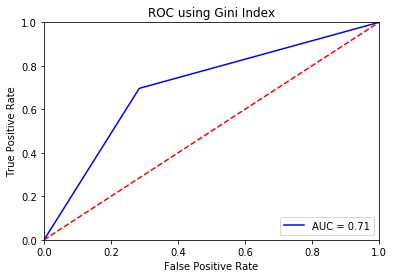

Computation time for Decision Trees using Gini Index is 0.3151555061340332 


In [233]:
# Dataset 1 = sgemm product 
#===========================

# Gini Index

start_time_1 = time.time()
model = DecisionTreeClassifier(criterion = "gini", max_depth = 3,max_leaf_nodes=2)
model.fit(sgemm_train_x, sgemm_train_y)

probs = model.predict_proba(sgemm_test_x)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(sgemm_test_y, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('ROC using Gini Index')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

end_time_1 = time.time()

print("Computation time for Decision Trees using Gini Index is {0} ".format(end_time_1-start_time_1))


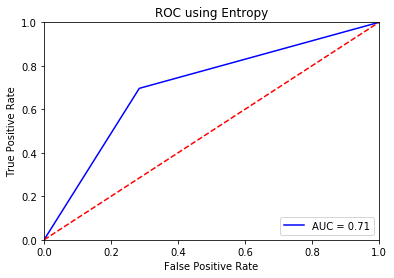

Computation time for Decision Trees using Entropy is 0.3390998840332031 


In [235]:
# Dataset 1 = sgemm product 
#===========================
# Entropy

start_time_1 = time.time()

model = DecisionTreeClassifier(criterion = "entropy", max_depth = 3,max_leaf_nodes=2)
model.fit(sgemm_train_x, sgemm_train_y)

probs = model.predict_proba(sgemm_test_x)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(sgemm_test_y, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('ROC using Entropy')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

end_time_1 = time.time()

print("Computation time for Decision Trees using Entropy is {0} ".format(end_time_1-start_time_1))

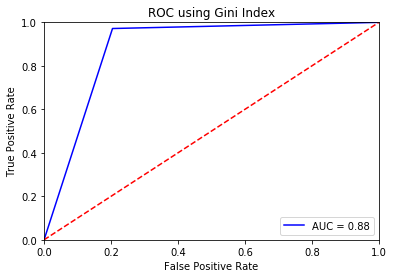

Computation time for Decision Trees using Gini Index is 0.2014636993408203 


In [239]:
# Dataset 2 = mushroom 
#===========================

# Gini Index

start_time_1 = time.time()

model = DecisionTreeClassifier(criterion = "gini", max_depth = 1,max_leaf_nodes=2)
model.fit(mush_train_x, mush_train_y)

probs = model.predict_proba(mush_test_x)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(mush_test_y, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('ROC using Gini Index')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

end_time_1 = time.time()

print("Computation time for Decision Trees using Gini Index is {0} ".format(end_time_1-start_time_1))


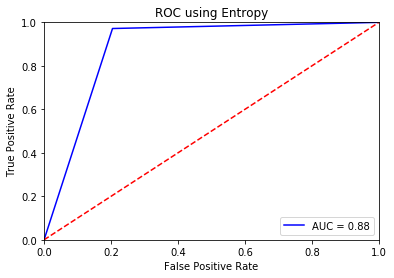

Computation time for Decision Trees using Entropy is 0.2473437786102295 


In [240]:
# Dataset 2 = mushroom 
#===========================

# Entropy

start_time_1 = time.time()
model = DecisionTreeClassifier(criterion = "entropy", max_depth = 1,max_leaf_nodes=2)
model.fit(mush_train_x, mush_train_y)

probs = model.predict_proba(mush_test_x)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(mush_test_y, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('ROC using Entropy')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

end_time_1 = time.time()

print("Computation time for Decision Trees using Entropy is {0} ".format(end_time_1-start_time_1))


# Experiment with pruning

### Changing depth of tree

[0.7090616764584996, 0.8107818959889751, 0.8830540847658422, 0.9385774038345301, 0.9685210705737288, 0.9950496844853848, 0.9983982495587631, 0.9999214235632601, 1.0, 1.0]
[0.7099922431422325, 0.8093787462097173, 0.8810803187363373, 0.9370425216839433, 0.9675340243988435, 0.9917636273887596, 0.9943445455186517, 0.9953176785840209, 0.9950215076510824, 0.995233058317467]


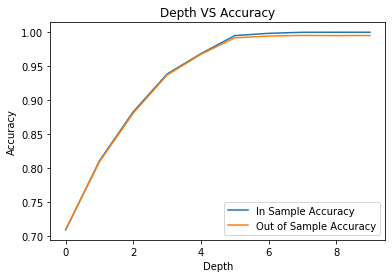

In [33]:
# Dataset 1 = sgemm product 
#===========================

l = [1,3,5,7,10,15,17,20,25,30]
#l = [1,2,3,4,5,6,7,8,9,10]
in_sample_acc =[]
out_sample_acc =[]

for i in l:
    clf_gini = DecisionTreeClassifier(criterion = "gini", max_depth=i) 
    clf_gini.fit(sgemm_train_x, sgemm_train_y)
    y_pred_in_sample = clf_gini.predict(sgemm_train_x)   
    y_pred_out_of_sample = clf_gini.predict(sgemm_test_x)
    in_acc = metrics.accuracy_score(sgemm_train_y, y_pred_in_sample)
    out_acc = metrics.accuracy_score(sgemm_test_y, y_pred_out_of_sample)
    in_sample_acc.append(in_acc)
    out_sample_acc.append(out_acc)
print(in_sample_acc)
print(out_sample_acc)


plt.title("Depth VS Accuracy")
plt.xlabel("Depth")
plt.ylabel("Accuracy")
plt.plot(in_sample_acc, label = 'In Sample Accuracy')
plt.plot(out_sample_acc, label = 'Out of Sample Accuracy')
#plt.xlim(0,30)
plt.legend()
plt.show()


[0.8897291593387266, 0.9542736545902216, 0.9859303552585297, 0.9945480126626802]
[0.8798195242001641, 0.9540607054963085, 0.9835931091058244, 0.9913863822805579]


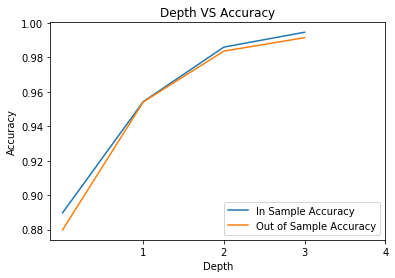

In [34]:
# Dataset 2 = mushroom 
#===========================

l = [1,2,3,4]
in_sample_acc =[]
out_sample_acc =[]

for i in l:
    clf_gini = DecisionTreeClassifier(criterion = "gini", max_depth=i) 
    clf_gini.fit(mush_train_x, mush_train_y)
    y_pred_in_sample = clf_gini.predict(mush_train_x)   
    y_pred_out_of_sample = clf_gini.predict(mush_test_x)
    in_acc = metrics.accuracy_score(mush_train_y, y_pred_in_sample)
    out_acc = metrics.accuracy_score(mush_test_y, y_pred_out_of_sample)
    in_sample_acc.append(in_acc)
    out_sample_acc.append(out_acc)
print(in_sample_acc)
print(out_sample_acc)


plt.title("Depth VS Accuracy")
plt.xlabel("Depth")
plt.ylabel("Accuracy")
plt.plot(in_sample_acc, label = 'In Sample Accuracy')
plt.plot(out_sample_acc, label = 'Out of Sample Accuracy')
#plt.xlim(0,30)
plt.xticks(l)
plt.legend()
plt.show()


### Changing number of leaf nodes

[0.7090616764584996, 0.7835460941466599, 0.8107818959889751, 0.830891419453108, 0.830891419453108, 0.830891419453108]
[0.7099922431422325, 0.7830336365559551, 0.8093787462097173, 0.8289683379169311, 0.8289683379169311, 0.8289683379169311]


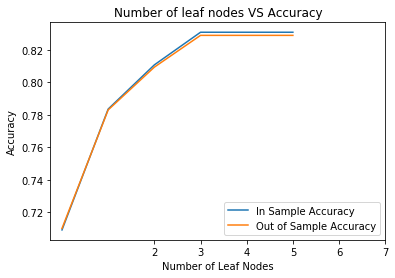

In [35]:
# Dataset 1 = sgemm product 
#===========================

l = [2,3,4,5,6,7]
#l = [1,2,3,4,5,6,7,8,9,10]
in_sample_acc =[]
out_sample_acc =[]

for i in l:
    clf_gini = DecisionTreeClassifier(criterion = "gini", max_leaf_nodes=i) 
    clf_gini.fit(sgemm_train_x, sgemm_train_y)
    y_pred_in_sample = clf_gini.predict(sgemm_train_x)   
    y_pred_out_of_sample = clf_gini.predict(sgemm_test_x)
    in_acc = metrics.accuracy_score(sgemm_train_y, y_pred_in_sample)
    out_acc = metrics.accuracy_score(sgemm_test_y, y_pred_out_of_sample)
    in_sample_acc.append(in_acc)
    out_sample_acc.append(out_acc)
print(in_sample_acc)
print(out_sample_acc)


plt.title("Number of leaf nodes VS Accuracy")
plt.xlabel("Number of Leaf Nodes")
plt.ylabel("Accuracy")
plt.plot(in_sample_acc, label = 'In Sample Accuracy')
plt.plot(out_sample_acc, label = 'Out of Sample Accuracy')
#plt.xlim(0,30)
plt.xticks(l)
plt.legend()
plt.show()

[0.8897291593387266, 0.9453042560675343, 0.9686950404502286, 0.9776644389729159, 0.9838199085473092, 0.9887442842068238]
[0.8798195242001641, 0.9454470877768663, 0.9696472518457753, 0.9782608695652174, 0.9835931091058244, 0.9868744872846595]


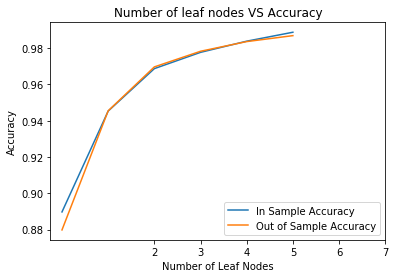

In [36]:
# Dataset 2 = mushroom 
#===========================

l = [2,3,4,5,6,7]
in_sample_acc =[]
out_sample_acc =[]

for i in l:
    clf_gini = DecisionTreeClassifier(criterion = "gini", max_leaf_nodes=i) 
    clf_gini.fit(mush_train_x, mush_train_y)
    y_pred_in_sample = clf_gini.predict(mush_train_x)   
    y_pred_out_of_sample = clf_gini.predict(mush_test_x)
    in_acc = metrics.accuracy_score(mush_train_y, y_pred_in_sample)
    out_acc = metrics.accuracy_score(mush_test_y, y_pred_out_of_sample)
    in_sample_acc.append(in_acc)
    out_sample_acc.append(out_acc)
print(in_sample_acc)
print(out_sample_acc)

plt.title("Number of leaf nodes VS Accuracy")
plt.xlabel("Number of Leaf Nodes")
plt.ylabel("Accuracy")
plt.plot(in_sample_acc, label = 'In Sample Accuracy')
plt.plot(out_sample_acc, label = 'Out of Sample Accuracy')
#plt.xlim(0,30)
plt.xticks(l)
plt.legend()
plt.show()


# Bagging

### Default number of trees set to 100

In [37]:
# Dataset 1 = sgemm product 
#===========================

acc_train, acc_test = cross_validation(sgemm_train_x, sgemm_train_y, sgemm_test_x, sgemm_test_y, 7)

print("In Sample accuracy from Bagging is {0}".format(acc_train))
print("Out of Sample accuracy from Bagging is {0}".format(acc_test))
print(" ")
print("Average In Sample accuracy from Bagging is {0}".format(statistics.mean(acc_train)))
print("Average Out of Sample accuracy from Bagging is {0}".format(statistics.mean(acc_test)))

In Sample accuracy from Bagging is [0.9948743985880418, 0.9955997195425642, 0.9952612364304538, 0.9954546553516598]
Out of Sample accuracy from Bagging is [0.995712512693219, 0.9946406408665237, 0.9954868554665464, 0.994415298696903]
 
Average In Sample accuracy from Bagging is 0.9952975024781799
Average Out of Sample accuracy from Bagging is 0.9950638269307981


In [38]:
# Dataset 2 = mushroom
#======================

acc_train, acc_test = cross_validation(mush_train_x, mush_train_y,mush_test_x, mush_test_y, 7)

print("In Sample accuracy from Bagging is {0}".format(acc_train))
print("Out of Sample accuracy from Bagging is {0}".format(acc_test))
print(" ")
print("Average In Sample accuracy from Bagging is {0}".format(statistics.mean(acc_train)))
print("Average Out of Sample accuracy from Bagging is {0}".format(statistics.mean(acc_test)))


In Sample accuracy from Bagging is [1.0, 1.0, 1.0, 0.9992967651195499]
Out of Sample accuracy from Bagging is [1.0, 1.0, 1.0, 0.9983606557377049]
 
Average In Sample accuracy from Bagging is 0.9998241912798875
Average Out of Sample accuracy from Bagging is 0.9995901639344262


### Experiment with different number of trees

[0.9911631730374024, 0.9940402794903411, 0.9946447136191098, 0.9950134184376587, 0.9953216798433306, 0.9952612364304538, 0.9952310147240153]
[0.9905789635413497, 0.9936957990884616, 0.9942881469216815, 0.9945984096963842, 0.9951343424273373, 0.9950920348797307, 0.9950638317043897]


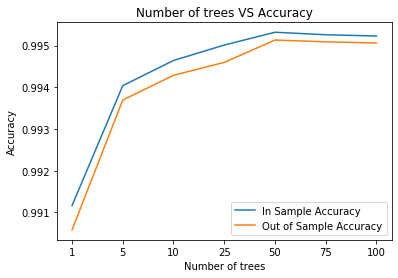

In [47]:
# Dataset 1 = sgemm product 
#===========================

ntree = [1,5,10,25,50,75,100]
a_train=[]
a_test=[]

for i in ntree:
    acc_train, acc_test = cross_validation(sgemm_train_x, sgemm_train_y, sgemm_test_x, sgemm_test_y, 7, i)
    mean_a_train = statistics.mean(acc_train)
    mean_a_test = statistics.mean(acc_test)
    a_train.append(mean_a_train)
    a_test.append(mean_a_test)
print(a_train) 
print(a_test)

xi = list(range(len(ntree)))
plt.title("Number of trees VS Accuracy")
plt.xlabel("Number of trees")
plt.ylabel("Accuracy")
plt.plot(a_train, label = 'In Sample Accuracy')
plt.plot(a_test, label = 'Out of Sample Accuracy')
plt.xticks(xi,ntree)
plt.legend()
plt.show()

[0.9994725738396625, 0.9994724501178327, 0.999648382559775, 0.9998241912798875, 0.9992967651195499, 0.9994725738396625, 0.9998241912798875, 0.9998241912798875, 0.9998241912798875, 0.9998241912798875, 0.9998241912798875, 0.9998241912798875, 0.9998241912798875]
[0.9995901639344262, 0.9995901639344262, 0.9995901639344262, 0.9995901639344262, 0.9995901639344262, 0.9991803278688525, 0.9995901639344262, 0.9995901639344262, 0.9995901639344262, 0.9995901639344262, 0.9995901639344262, 0.9995901639344262, 0.9995901639344262]


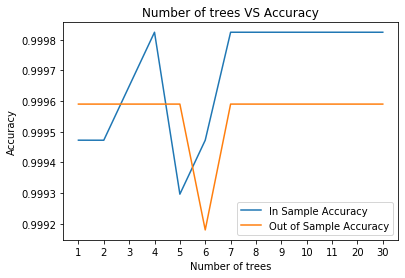

In [144]:
# Dataset 2 = mushroom
#======================

ntree = [1,2,3,4,5,6,7,8,9,10,11,20,30]
a_train=[]
a_test=[]

for i in ntree:
    acc_train, acc_test = cross_validation(mush_train_x, mush_train_y, mush_test_x, mush_test_y, 7, i)
    mean_a_train = statistics.mean(acc_train)
    mean_a_test = statistics.mean(acc_test)
    a_train.append(mean_a_train)
    a_test.append(mean_a_test)
print(a_train) 
print(a_test)

xi = list(range(len(ntree)))
plt.title("Number of trees VS Accuracy")
plt.xlabel("Number of trees")
plt.ylabel("Accuracy")
plt.plot(a_train, label = 'In Sample Accuracy')
plt.plot(a_test, label = 'Out of Sample Accuracy')
plt.xticks(xi,ntree)
#plt.ylim(0.998,1)
plt.legend()
plt.show()

# Random Forest

### Default number of trees set to 100, number of features set to 5

In [61]:
# Dataset 1 = sgemm product 
#===========================

acc_train, acc_test = cross_validation(sgemm_train_x, sgemm_train_y, sgemm_test_x, sgemm_test_y, 8)

print("In Sample accuracy from Random Forest is {0}".format(acc_train))
print("Out of Sample accuracy from Random Forest is {0}".format(acc_test))
print(" ")
print("Average In Sample accuracy from Random Forest is {0}".format(statistics.mean(acc_train)))
print("Average Out of Sample accuracy from Random Forest is {0}".format(statistics.mean(acc_test)))

In Sample accuracy from Random Forest is [0.9930852735668867, 0.9932545151229419, 0.9926500809941733, 0.9930852735668867]
Out of Sample accuracy from Random Forest is [0.9939072548798376, 0.9920455827597879, 0.9937944262665012, 0.9914255091103966]
 
Average In Sample accuracy from Random Forest is 0.9930187858127222
Average Out of Sample accuracy from Random Forest is 0.9927931932541308


In [62]:
# Dataset 2 = mushroom
#======================

acc_train, acc_test = cross_validation(mush_train_x, mush_train_y,mush_test_x, mush_test_y, 8)

print("In Sample accuracy from Random Forest is {0}".format(acc_train))
print("Out of Sample accuracy from Random Forest is {0}".format(acc_test))
print(" ")
print("Average In Sample accuracy from Random Forest is {0}".format(statistics.mean(acc_train)))
print("Average Out of Sample accuracy from Random Forest is {0}".format(statistics.mean(acc_test)))

In Sample accuracy from Random Forest is [1.0, 1.0, 1.0, 1.0]
Out of Sample accuracy from Random Forest is [1.0, 1.0, 1.0, 1.0]
 
Average In Sample accuracy from Random Forest is 1.0
Average Out of Sample accuracy from Random Forest is 1.0


### Experiment with different number of trees

[0.9754176639829791, 0.9885338845772588, 0.9907158917821136, 0.9922934648581998, 0.9928555885979546, 0.9929281206934069, 0.9930490075191606]
[0.9742895488937389, 0.988364716325399, 0.9905084424756201, 0.9922431641068982, 0.9923136740342472, 0.9923983018590383, 0.9929765357728093]


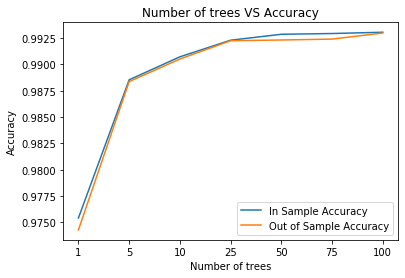

In [63]:
# Dataset 1 = sgemm product 
#===========================

ntree = [1,5,10,25,50,75,100]
a_train=[]
a_test=[]

for i in ntree:
    acc_train, acc_test = cross_validation(sgemm_train_x, sgemm_train_y, sgemm_test_x, sgemm_test_y, 8, i)
    mean_a_train = statistics.mean(acc_train)
    mean_a_test = statistics.mean(acc_test)
    a_train.append(mean_a_train)
    a_test.append(mean_a_test)
print(a_train) 
print(a_test)

xi = list(range(len(ntree)))
plt.title("Number of trees VS Accuracy")
plt.xlabel("Number of trees")
plt.ylabel("Accuracy")
plt.plot(a_train, label = 'In Sample Accuracy')
plt.plot(a_test, label = 'Out of Sample Accuracy')
plt.xticks(xi,ntree)
plt.legend()
plt.show()

[0.9982414179115557, 0.9998241912798875, 1.0, 1.0, 1.0, 1.0]
[0.9963081105817115, 0.9991803278688525, 1.0, 1.0, 1.0, 1.0]


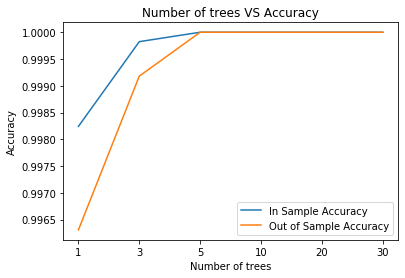

In [64]:
# Dataset 2 = mushroom
#======================

ntree = [1,3,5,10,20,30]
a_train=[]
a_test=[]

for i in ntree:
    acc_train, acc_test = cross_validation(mush_train_x, mush_train_y, mush_test_x, mush_test_y, 8, i)
    mean_a_train = statistics.mean(acc_train)
    mean_a_test = statistics.mean(acc_test)
    a_train.append(mean_a_train)
    a_test.append(mean_a_test)
print(a_train) 
print(a_test)

xi = list(range(len(ntree)))
plt.title("Number of trees VS Accuracy")
plt.xlabel("Number of trees")
plt.ylabel("Accuracy")
plt.plot(a_train, label = 'In Sample Accuracy')
plt.plot(a_test, label = 'Out of Sample Accuracy')
plt.xticks(xi,ntree)
plt.legend()
plt.show()

### Experiment with different number of features

[0.9906675370518121, 0.9919791591112401, 0.9931154952733251, 0.9938529049104229, 0.9943727182611639, 0.9947716447861512, 0.9949046202944803, 0.9952612364304538]
[0.9904379110671083, 0.9916931246168834, 0.9927931924585321, 0.9936111903580372, 0.9942599389727489, 0.9945561172651513, 0.9948945919667798, 0.9950215209743887]


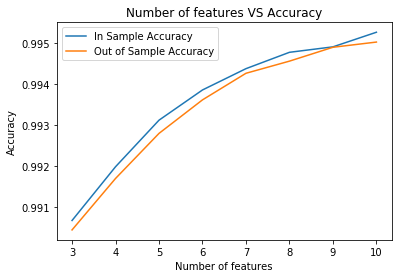

In [67]:
# Dataset 1 = sgemm product 
#===========================

ntree = 100
nfeat = [3,4,5,6,7,8,9,10]

a_train=[]
a_test=[]

for i in nfeat:
    acc_train, acc_test = cross_validation(sgemm_train_x, sgemm_train_y, sgemm_test_x, sgemm_test_y, 8, ntree,i)
    mean_a_train = statistics.mean(acc_train)
    mean_a_test = statistics.mean(acc_test)
    a_train.append(mean_a_train)
    a_test.append(mean_a_test)
print(a_train) 
print(a_test)

xi = list(range(len(nfeat)))
plt.title("Number of features VS Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Accuracy")
plt.plot(a_train, label = 'In Sample Accuracy')
plt.plot(a_test, label = 'Out of Sample Accuracy')
plt.xticks(xi,nfeat)
plt.legend()
plt.show()

[1.0, 1.0, 1.0, 0.9998241912798875, 0.9998241912798875, 0.9998241912798875, 0.9998241912798875, 0.9998241912798875, 0.9998241912798875]
[1.0, 1.0, 1.0, 0.9995901639344262, 0.9995901639344262, 0.9995901639344262, 0.9995901639344262, 0.9995901639344262, 0.9995901639344262]


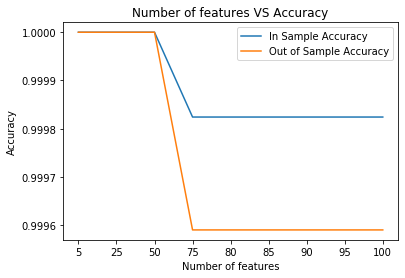

In [148]:
# Dataset 2 = mushroom
#======================

ntree = 100
nfeat = [5,25,50,75,80,85,90,95,100]

a_train=[]
a_test=[]

for i in nfeat:
    acc_train, acc_test = cross_validation(mush_train_x, mush_train_y, mush_test_x, mush_test_y, 8, ntree, i)
    mean_a_train = statistics.mean(acc_train)
    mean_a_test = statistics.mean(acc_test)
    a_train.append(mean_a_train)
    a_test.append(mean_a_test)
print(a_train) 
print(a_test)

xi = list(range(len(nfeat)))
plt.title("Number of features VS Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Accuracy")
plt.plot(a_train, label = 'In Sample Accuracy')
plt.plot(a_test, label = 'Out of Sample Accuracy')
plt.xticks(xi,nfeat)
plt.legend()
plt.show()

# Boosting

## AdaBoost

In [75]:
# Dataset 1 = sgemm product 
#===========================

acc_train, acc_test = cross_validation(sgemm_train_x, sgemm_train_y, sgemm_test_x, sgemm_test_y, 9)

print("In Sample accuracy from AdaBoost is {0}".format(acc_train))
print("Out of Sample accuracy from AdaBoost is {0}".format(acc_test))
print(" ")
print("Average In Sample accuracy from AdaBoost is {0}".format(statistics.mean(acc_train)))
print("Average Out of Sample accuracy from AdaBoost is {0}".format(statistics.mean(acc_test)))

In Sample accuracy from AdaBoost is [0.9096008317013612, 0.9091656391286478, 0.9106162810376925, 0.9120669229467373]
Out of Sample accuracy from AdaBoost is [0.9095678664109218, 0.9148143969310617, 0.9064650795441724, 0.9122242906301122]
 
Average In Sample accuracy from AdaBoost is 0.9103624187036097
Average Out of Sample accuracy from AdaBoost is 0.9107679083790671


In [74]:
# Dataset 2 = mushroom
#======================

acc_train, acc_test = cross_validation(mush_train_x, mush_train_y,mush_test_x, mush_test_y, 9)

print("In Sample accuracy from AdaBoost is {0}".format(acc_train))
print("Out of Sample accuracy from AdaBoost is {0}".format(acc_test))
print(" ")
print("Average In Sample accuracy from AdaBoost is {0}".format(statistics.mean(acc_train)))
print("Average Out of Sample accuracy from AdaBoost is {0}".format(statistics.mean(acc_test)))

In Sample accuracy from AdaBoost is [1.0, 1.0, 1.0, 1.0]
Out of Sample accuracy from AdaBoost is [1.0, 1.0, 1.0, 1.0]
 
Average In Sample accuracy from AdaBoost is 1.0
Average Out of Sample accuracy from AdaBoost is 1.0


### Experiment with different number of trees

[0.7090616764584996, 0.8457121442905152, 0.9094376344865936, 0.9212543217040207, 0.9122784748918062, 0.914291240540606, 0.9138741809917555, 0.9133483232997268, 0.9118251492952298, 0.9132455694978361, 0.9114322671115302, 0.9105316602596649, 0.9103624187036097, 0.9102294431952807, 0.9101931771475544, 0.9101931771475544]
[0.7099922749920295, 0.8474296597101879, 0.9100627470488845, 0.920358222764061, 0.9118539076503878, 0.9142091516486767, 0.9138988467072474, 0.9136168038154567, 0.911726951592426, 0.9138142284296397, 0.9119525992719153, 0.9111910037450991, 0.9107679083790671, 0.9105845666559872, 0.9105845666559872, 0.9106268757947911]


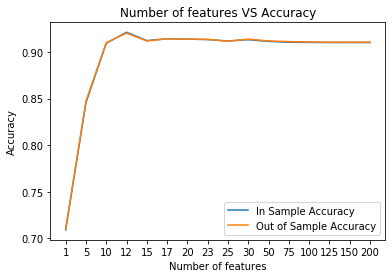

In [81]:
# Dataset 1 = sgemm product 
#===========================

ntree = [1,5,10,12,15,17,20,23,25,30,50,75,100,125,150,200]

a_train=[]
a_test=[]

for i in ntree:
    acc_train, acc_test = cross_validation(sgemm_train_x, sgemm_train_y, sgemm_test_x, sgemm_test_y, 9, i)
    mean_a_train = statistics.mean(acc_train)
    mean_a_test = statistics.mean(acc_test)
    a_train.append(mean_a_train)
    a_test.append(mean_a_test)
print(a_train) 
print(a_test)

xi = list(range(len(ntree)))
plt.title("Number of trees VS Accuracy")
plt.xlabel("Number of trees")
plt.ylabel("Accuracy")
plt.plot(a_train, label = 'In Sample Accuracy')
plt.plot(a_test, label = 'Out of Sample Accuracy')
plt.xticks(xi,ntree)
plt.legend()
plt.show()

[0.8897304447750292, 0.9398525087322868, 0.9825887506173719, 0.9892707191999454, 0.9709816634350525, 0.9890967663072795, 0.9898016095715166, 0.9919102007163989, 0.9975383067529354, 0.9987692152373826, 0.9987692152373826, 0.9963078931558074, 1.0, 0.9994725738396625, 0.9994725738396625, 1.0, 1.0, 1.0]
[0.8798177609087727, 0.9466735309160408, 0.9815405529085575, 0.9893308029825836, 0.9733371019408329, 0.9917958760666505, 0.9913907507604511, 0.9946687663194164, 0.9979508196721312, 0.9987704918032787, 0.9987704918032787, 0.9971311475409836, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


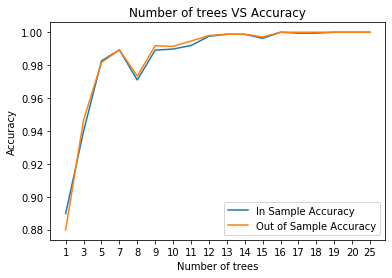

In [84]:
# Dataset 2 = mushroom
#======================

ntree = [1,3,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,25]

a_train=[]
a_test=[]

for i in ntree:
    acc_train, acc_test = cross_validation(mush_train_x, mush_train_y, mush_test_x, mush_test_y, 9, i)
    mean_a_train = statistics.mean(acc_train)
    mean_a_test = statistics.mean(acc_test)
    a_train.append(mean_a_train)
    a_test.append(mean_a_test)
print(a_train) 
print(a_test)

xi = list(range(len(ntree)))
plt.title("Number of trees VS Accuracy")
plt.xlabel("Number of trees")
plt.ylabel("Accuracy")
plt.plot(a_train, label = 'In Sample Accuracy')
plt.plot(a_test, label = 'Out of Sample Accuracy')
plt.xticks(xi,ntree)
plt.legend()
plt.show()

## Stochastic Gradient Boost

In [76]:
# Dataset 1 = sgemm product 
#===========================

acc_train, acc_test = cross_validation(sgemm_train_x, sgemm_train_y, sgemm_test_x, sgemm_test_y, 10)

print("In Sample accuracy from Stochastic Gradient Boost is {0}".format(acc_train))
print("Out of Sample accuracy from Stochastic Gradient Boost is {0}".format(acc_test))
print(" ")
print("Average In Sample accuracy from Stochastic Gradient Boost is {0}".format(statistics.mean(acc_train)))
print("Average Out of Sample accuracy from Stochastic Gradient Boost is {0}".format(statistics.mean(acc_test)))

In Sample accuracy from Stochastic Gradient Boost is [0.9563598559029037, 0.9507990619182322, 0.953095911607553, 0.9536036362757186]
Out of Sample accuracy from Stochastic Gradient Boost is [0.9556019406521494, 0.9517657677987138, 0.9492271239986461, 0.9513171997517911]
 
Average In Sample accuracy from Stochastic Gradient Boost is 0.9534646164261019
Average Out of Sample accuracy from Stochastic Gradient Boost is 0.9519780080503251


In [77]:
# Dataset 2 = mushroom
#======================

acc_train, acc_test = cross_validation(mush_train_x, mush_train_y,mush_test_x, mush_test_y, 10)

print("In Sample accuracy from Stochastic Gradient Boost is {0}".format(acc_train))
print("Out of Sample accuracy from Stochastic Gradient Boost is {0}".format(acc_test))
print(" ")
print("Average In Sample accuracy from Stochastic Gradient Boost is {0}".format(statistics.mean(acc_train)))
print("Average Out of Sample accuracy from Stochastic Gradient Boost is {0}".format(statistics.mean(acc_test)))

In Sample accuracy from Stochastic Gradient Boost is [1.0, 0.9985935302390999, 1.0, 0.9992967651195499]
Out of Sample accuracy from Stochastic Gradient Boost is [1.0, 1.0, 1.0, 0.9983606557377049]
 
Average In Sample accuracy from Stochastic Gradient Boost is 0.9994725738396625
Average Out of Sample accuracy from Stochastic Gradient Boost is 0.9995901639344262


### Experiment with different number of trees

[0.7064746983873698, 0.7980343802132444, 0.8453736611784047, 0.857069461570078, 0.8681426948091198, 0.882479872343512, 0.9364679287251275, 0.9502127608133266, 0.9534646164261019, 0.9602947220811876, 0.9628212567394405, 0.9641510118227316]
[0.70587407834117, 0.7972216205375089, 0.8441576728857592, 0.8564700953160875, 0.866046060284442, 0.8805021078239671, 0.9358719438773788, 0.9488893717005611, 0.9519780080503251, 0.9593540624897905, 0.9617093335384324, 0.9633453189946605]


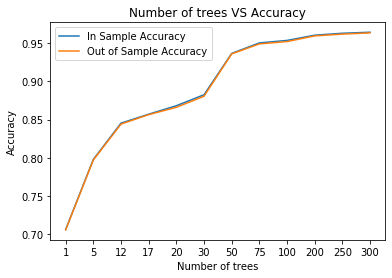

In [86]:
# Dataset 1 = sgemm product 
#===========================

ntree = [1,5,12,17,20,30,50,75,100,200,250,300]

a_train=[]
a_test=[]

for i in ntree:
    acc_train, acc_test = cross_validation(sgemm_train_x, sgemm_train_y, sgemm_test_x, sgemm_test_y, 10, i)
    mean_a_train = statistics.mean(acc_train)
    mean_a_test = statistics.mean(acc_test)
    a_train.append(mean_a_train)
    a_test.append(mean_a_test)
print(a_train) 
print(a_test)

xi = list(range(len(ntree)))
plt.title("Number of trees VS Accuracy")
plt.xlabel("Number of trees")
plt.ylabel("Accuracy")
plt.plot(a_train, label = 'In Sample Accuracy')
plt.plot(a_test, label = 'Out of Sample Accuracy')
plt.xticks(xi,ntree)
plt.legend()
plt.show()

[0.9641510118227316, 0.9655351659776118, 0.9667379898938614, 0.9680375232707139]
[0.9633453189946605, 0.9649390064504654, 0.9658416194451838, 0.9670263031776445]


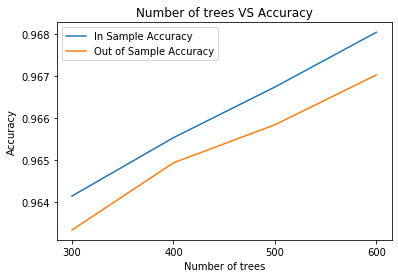

In [87]:
ntree = [300,400,500,600]

a_train=[]
a_test=[]

for i in ntree:
    acc_train, acc_test = cross_validation(sgemm_train_x, sgemm_train_y, sgemm_test_x, sgemm_test_y, 10, i)
    mean_a_train = statistics.mean(acc_train)
    mean_a_test = statistics.mean(acc_test)
    a_train.append(mean_a_train)
    a_test.append(mean_a_test)
print(a_train) 
print(a_test)

xi = list(range(len(ntree)))
plt.title("Number of trees VS Accuracy")
plt.xlabel("Number of trees")
plt.ylabel("Accuracy")
plt.plot(a_train, label = 'In Sample Accuracy')
plt.plot(a_test, label = 'Out of Sample Accuracy')
plt.xticks(xi,ntree)
plt.legend()
plt.show()

[0.9843470852621566, 0.9852268711936979, 0.9857542973540354, 0.9903254477987907, 0.9924366371020983, 0.9941959615215212, 0.9943718939634635, 0.9943718939634635, 0.996483083266771, 0.996483083266771, 0.9977139917512181, 0.9992967651195499, 0.9994725738396625, 0.9994725738396625, 0.9994725738396625]
[0.9823608980053299, 0.983592425098926, 0.9835917521333011, 0.9901504751137312, 0.991792511238526, 0.9946660744569167, 0.9958976015505128, 0.9958976015505128, 0.9983606557377049, 0.9983606557377049, 0.9987704918032787, 0.9991803278688525, 0.9995901639344262, 0.9995901639344262, 0.9995901639344262]


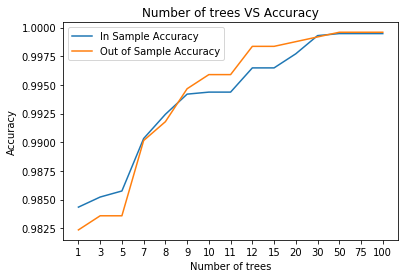

In [92]:
# Dataset 2 = mushroom
#======================

ntree = [1,3,5,7,8,9,10,11,12,15,20,30,50,75,100]

a_train=[]
a_test=[]

for i in ntree:
    acc_train, acc_test = cross_validation(mush_train_x, mush_train_y, mush_test_x, mush_test_y, 10, i)
    mean_a_train = statistics.mean(acc_train)
    mean_a_test = statistics.mean(acc_test)
    a_train.append(mean_a_train)
    a_test.append(mean_a_test)
print(a_train) 
print(a_test)

xi = list(range(len(ntree)))
plt.title("Number of trees VS Accuracy")
plt.xlabel("Number of trees")
plt.ylabel("Accuracy")
plt.plot(a_train, label = 'In Sample Accuracy')
plt.plot(a_test, label = 'Out of Sample Accuracy')
plt.xticks(xi,ntree)
plt.legend()
plt.show()

## XG Boost

In [124]:
# Dataset 1 = sgemm product 
#===========================

model = XGBClassifier()
model.fit(sgemm_train_x, sgemm_train_y)
       
y_pred_in_sample = model.predict(sgemm_train_x)   
y_pred_out_of_sample = model.predict(sgemm_test_x)

acc_train= metrics.accuracy_score(sgemm_train_y, y_pred_in_sample)
acc_test = metrics.accuracy_score(sgemm_test_y, y_pred_out_of_sample)


print("In Sample accuracy from XG Boost is {0}".format(acc_train))
print("Out of Sample accuracy from XG Boost is {0}".format(acc_test))


In Sample accuracy from XG Boost is 0.9906070936389352
Out of Sample accuracy from XG Boost is 0.9888160214371342


In [123]:
# Dataset 2 = mushroom
#======================

model = XGBClassifier()
model.fit(mush_train_x, mush_train_y)
       
y_pred_in_sample = model.predict(mush_train_x)   
y_pred_out_of_sample = model.predict(mush_test_x)

acc_train= metrics.accuracy_score(mush_train_y, y_pred_in_sample)
acc_test = metrics.accuracy_score(mush_test_y, y_pred_out_of_sample)

print("In Sample accuracy from XG Boost is {0}".format(acc_train))
print("Out of Sample accuracy from XG Boost is {0}".format(acc_test))


In Sample accuracy from XG Boost is 1.0
Out of Sample accuracy from XG Boost is 1.0


### Experiment with different number of trees

In Sample accuracy from XG Boost is [0.9229709146297237, 0.9418897028601823, 0.9575324581127149, 0.9766386209230918, 0.9844418655254951, 0.988721259157177, 0.9906070936389352, 0.9935688208699016, 0.9953579458910568, 0.9964157056164019, 0.9970261840864583]
Out of Sample accuracy from XG Boost is [0.9215852196601086, 0.9401452647909174, 0.9563359424582187, 0.9751780551442071, 0.9824412946900782, 0.9868274451731189, 0.9888160214371342, 0.9914110429447853, 0.9929483111205134, 0.9938509272970877, 0.9941753049855441]


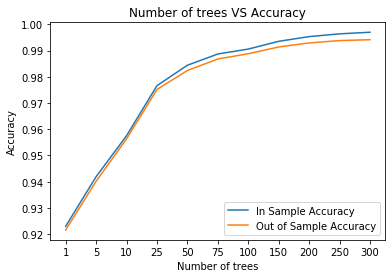

In [126]:
# Dataset 1 = sgemm product 
#===========================

ntree = [1,5,10,25,50,75,100,150,200,250,300]
a_train = []
a_test = []

for i in ntree:
    model = XGBClassifier(n_estimators=i)
    model.fit(sgemm_train_x, sgemm_train_y)

    y_pred_in_sample = model.predict(sgemm_train_x)   
    y_pred_out_of_sample = model.predict(sgemm_test_x)

    acc_train= metrics.accuracy_score(sgemm_train_y, y_pred_in_sample)
    acc_test = metrics.accuracy_score(sgemm_test_y, y_pred_out_of_sample)
    a_train.append(acc_train)
    a_test.append(acc_test)

print("In Sample accuracy from XG Boost is {0}".format(a_train))
print("Out of Sample accuracy from XG Boost is {0}".format(a_test))

xi = list(range(len(ntree)))
plt.title("Number of trees VS Accuracy")
plt.xlabel("Number of trees")
plt.ylabel("Accuracy")
plt.plot(a_train, label = 'In Sample Accuracy')
plt.plot(a_test, label = 'Out of Sample Accuracy')
plt.xticks(xi,ntree)
plt.legend()
plt.show()


In Sample accuracy from XG Boost is [0.9989447766443897, 0.9989447766443897, 1.0, 1.0, 1.0, 1.0, 1.0]
Out of Sample accuracy from XG Boost is [0.9991796554552912, 0.9991796554552912, 1.0, 1.0, 1.0, 1.0, 1.0]


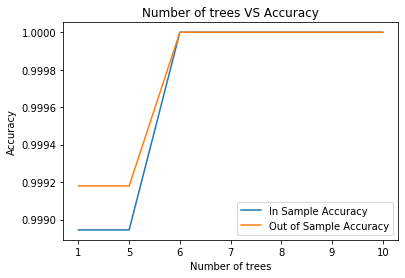

In [136]:
# Dataset 2 = mushroom
#======================

ntree = [1,5,6,7,8,9,10]
a_train = []
a_test = []

for i in ntree:
    model = XGBClassifier(n_estimators=i)
    model.fit(mush_train_x, mush_train_y)

    y_pred_in_sample = model.predict(mush_train_x)   
    y_pred_out_of_sample = model.predict(mush_test_x)

    acc_train= metrics.accuracy_score(mush_train_y, y_pred_in_sample)
    acc_test = metrics.accuracy_score(mush_test_y, y_pred_out_of_sample)
    a_train.append(acc_train)
    a_test.append(acc_test)

print("In Sample accuracy from XG Boost is {0}".format(a_train))
print("Out of Sample accuracy from XG Boost is {0}".format(a_test))

xi = list(range(len(ntree)))
plt.title("Number of trees VS Accuracy")
plt.xlabel("Number of trees")
plt.ylabel("Accuracy")
plt.plot(a_train, label = 'In Sample Accuracy')
plt.plot(a_test, label = 'Out of Sample Accuracy')
plt.xticks(xi,ntree)
plt.legend()
plt.show()

### Experiment with multiple depth of tree

In Sample accuracy from XG Boost is [0.9347513357994246, 0.9644048741568144, 0.9841033824133846, 0.9954909213993859, 0.9995345857208482, 0.9999879113174246, 0.9999939556587123, 0.9999939556587123]
Out of Sample accuracy from XG Boost is [0.9341795359988717, 0.9630632536492489, 0.9824412946900782, 0.9932585854312108, 0.9963613285381849, 0.9965869825823285, 0.9966857062266413, 0.9966857062266413]


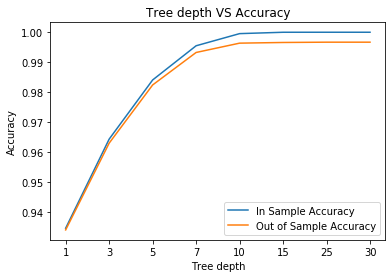

In [132]:
# Dataset 1 = sgemm product 
#===========================

ndepth = [1,3,5,7,10,15,25,30]
a_train = []
a_test = []

for i in ndepth:
    model = XGBClassifier(max_depth=i)
    model.fit(sgemm_train_x, sgemm_train_y)

    y_pred_in_sample = model.predict(sgemm_train_x)   
    y_pred_out_of_sample = model.predict(sgemm_test_x)

    acc_train= metrics.accuracy_score(sgemm_train_y, y_pred_in_sample)
    acc_test = metrics.accuracy_score(sgemm_test_y, y_pred_out_of_sample)
    a_train.append(acc_train)
    a_test.append(acc_test)

print("In Sample accuracy from XG Boost is {0}".format(a_train))
print("Out of Sample accuracy from XG Boost is {0}".format(a_test))

xi = list(range(len(ndepth)))
plt.title("Tree depth VS Accuracy")
plt.xlabel("Tree depth")
plt.ylabel("Accuracy")
plt.plot(a_train, label = 'In Sample Accuracy')
plt.plot(a_test, label = 'Out of Sample Accuracy')
plt.xticks(xi,ndepth)
plt.legend()
plt.show()


In Sample accuracy from XG Boost is [0.9989447766443897, 1.0, 1.0, 1.0, 1.0]
Out of Sample accuracy from XG Boost is [0.9991796554552912, 1.0, 1.0, 1.0, 1.0]


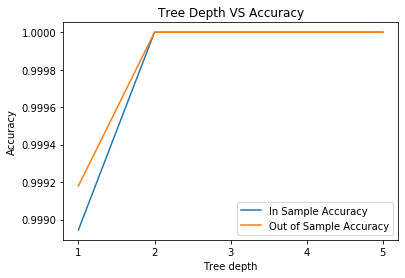

In [139]:
# Dataset 2 = mushroom
#======================

ndepth = [1,2,3,4,5]
a_train = []
a_test = []

for i in ndepth:
    model = XGBClassifier(max_depth=i)
    model.fit(mush_train_x, mush_train_y)

    y_pred_in_sample = model.predict(mush_train_x)   
    y_pred_out_of_sample = model.predict(mush_test_x)

    acc_train= metrics.accuracy_score(mush_train_y, y_pred_in_sample)
    acc_test = metrics.accuracy_score(mush_test_y, y_pred_out_of_sample)
    a_train.append(acc_train)
    a_test.append(acc_test)

print("In Sample accuracy from XG Boost is {0}".format(a_train))
print("Out of Sample accuracy from XG Boost is {0}".format(a_test))

xi = list(range(len(ndepth)))
plt.title("Tree Depth VS Accuracy")
plt.xlabel("Tree depth")
plt.ylabel("Accuracy")
plt.plot(a_train, label = 'In Sample Accuracy')
plt.plot(a_test, label = 'Out of Sample Accuracy')
plt.xticks(xi,ndepth)
plt.legend()
plt.show()

### Experiment with multiple learning rates

In Sample accuracy from XG Boost is [0.7064746983873698, 0.7064746983873698, 0.30629699475351174, 0.7893365731002635, 0.9976547955803776, 0.9942095210463964, 0.9800778511157854, 0.935706341722879, 0.9340985469403544, 0.9229709146297237]
Out of Sample accuracy from XG Boost is [0.7058740568366124, 0.7058740568366124, 0.30646639870248926, 0.788378816726606, 0.9945560961850363, 0.9916649037444468, 0.978337211762217, 0.9336154008885128, 0.9327127847119385, 0.9215852196601086]


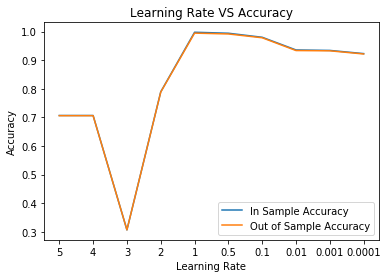

In [142]:
# Dataset 1 = sgemm product 
#===========================

nrate = [5,4,3,2,1,0.5,0.1,0.01,0.001,0.0001]
a_train = []
a_test = []

for i in nrate:
    model = XGBClassifier(learning_rate=i)
    model.fit(sgemm_train_x, sgemm_train_y)

    y_pred_in_sample = model.predict(sgemm_train_x)   
    y_pred_out_of_sample = model.predict(sgemm_test_x)

    acc_train= metrics.accuracy_score(sgemm_train_y, y_pred_in_sample)
    acc_test = metrics.accuracy_score(sgemm_test_y, y_pred_out_of_sample)
    a_train.append(acc_train)
    a_test.append(acc_test)

print("In Sample accuracy from XG Boost is {0}".format(a_train))
print("Out of Sample accuracy from XG Boost is {0}".format(a_test))

xi = list(range(len(nrate)))
plt.title("Learning Rate VS Accuracy")
plt.xlabel("Learning Rate")
plt.ylabel("Accuracy")
plt.plot(a_train, label = 'In Sample Accuracy')
plt.plot(a_test, label = 'Out of Sample Accuracy')
plt.xticks(xi,nrate)
plt.legend()
plt.show()

In Sample accuracy from XG Boost is [0.4836440379880408, 0.5163559620119592, 0.4836440379880408, 1.0, 1.0, 1.0, 1.0, 0.9989447766443897, 0.9989447766443897, 0.9989447766443897]
Out of Sample accuracy from XG Boost is [0.4782608695652174, 0.5217391304347826, 0.4782608695652174, 1.0, 1.0, 1.0, 1.0, 0.9991796554552912, 0.9991796554552912, 0.9991796554552912]


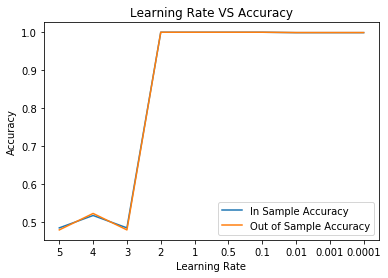

In [143]:
# Dataset 2 = mushroom
#======================

nrate = [5,4,3,2,1,0.5,0.1,0.01,0.001,0.0001]
a_train = []
a_test = []

for i in nrate:
    model = XGBClassifier(learning_rate=i)
    model.fit(mush_train_x, mush_train_y)

    y_pred_in_sample = model.predict(mush_train_x)   
    y_pred_out_of_sample = model.predict(mush_test_x)

    acc_train= metrics.accuracy_score(mush_train_y, y_pred_in_sample)
    acc_test = metrics.accuracy_score(mush_test_y, y_pred_out_of_sample)
    a_train.append(acc_train)
    a_test.append(acc_test)

print("In Sample accuracy from XG Boost is {0}".format(a_train))
print("Out of Sample accuracy from XG Boost is {0}".format(a_test))

xi = list(range(len(nrate)))
plt.title("Learning Rate VS Accuracy")
plt.xlabel("Learning Rate")
plt.ylabel("Accuracy")
plt.plot(a_train, label = 'In Sample Accuracy')
plt.plot(a_test, label = 'Out of Sample Accuracy')
plt.xticks(xi,nrate)
plt.legend()
plt.show()